In [10]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import timeit
import os

DATA_DIR="/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Train"
BATCH_SIZE = 128
IMG_SIZE = 64
CHANNELS = 3
INPUT_VECTOR_DIM = 100
FEATURE_MAP_DIM = 64
LR = 2e-4
BETA1 = 0.5
EPOCHS = 500
RANDOM_SEED = 42
CHECKPOINT = "/kaggle/working/checkpoints"

if not os.path.exists(CHECKPOINT):
    os.makedirs(CHECKPOINT)
    print(f"Created checkpoint directory: {CHECKPOINT}")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class Discriminator(nn.Module):
  def __init__(self, feature_map_dim, channels):
    super(Discriminator, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=channels, out_channels=feature_map_dim*2, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_2 = nn.Conv2d(in_channels=feature_map_dim*2, out_channels=feature_map_dim*4, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_3 = nn.Conv2d(in_channels=feature_map_dim*4, out_channels=feature_map_dim*8, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_4 = nn.Conv2d(in_channels=feature_map_dim*8, out_channels=feature_map_dim*16, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_5 = nn.Conv2d(in_channels=feature_map_dim*16, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False )

    self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*4)
    self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
    self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*16)

    self.sigmoid = nn.Sigmoid()

  def forward(self, inp):
    x = self.conv_1(inp)
    x = self.leaky_relu(x)

    x = self.conv_2(x)
    x = self.batch_norm_1(x)
    x = self.leaky_relu(x)

    x = self.conv_3(x)
    x = self.batch_norm_2(x)
    x = self.leaky_relu(x)

    x = self.conv_4(x)
    x = self.batch_norm_3(x)
    x = self.leaky_relu(x)

    x = self.conv_5(x)
    out = self.sigmoid(x)

    return out

In [11]:
discriminator = Discriminator(FEATURE_MAP_DIM, CHANNELS).to(device)
x =  torch.randn(BATCH_SIZE, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
dis_out = discriminator(x)
print(dis_out.size())

torch.Size([128, 1, 1, 1])


In [12]:
class Generator(nn.Module):
  def __init__(self, input_vector, feature_map_dim, channels):
    super(Generator, self).__init__()
    self.convt_1 = nn.ConvTranspose2d(in_channels=input_vector, out_channels=feature_map_dim*16, kernel_size=4, stride=1, padding=0, bias=False)
    self.convt_2 = nn.ConvTranspose2d(in_channels=feature_map_dim*16, out_channels=feature_map_dim*8, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt_3 = nn.ConvTranspose2d(in_channels=feature_map_dim*8, out_channels=feature_map_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt_4 = nn.ConvTranspose2d(in_channels=feature_map_dim*4, out_channels=feature_map_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt_5 = nn.ConvTranspose2d(in_channels=feature_map_dim*2, out_channels=channels, kernel_size=4, stride=2, padding=1, bias=False)

    self.relu = nn.ReLU(True)

    self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
    self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
    self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
    self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)

    self.tanh = nn.Tanh()

  def forward(self, inp):
    x = self.convt_1(inp)
    x = self.batch_norm_1(x)
    x = self.relu(x)

    x = self.convt_2(x)
    x = self.batch_norm_2(x)
    x = self.relu(x)

    x = self.convt_3(x)
    x = self.batch_norm_3(x)
    x = self.relu(x)

    x = self.convt_4(x)
    x = self.batch_norm_4(x)
    x = self.relu(x)

    x = self.convt_5(x)
    out = self.tanh(x)

    return out

In [13]:
generator = Generator(INPUT_VECTOR_DIM, FEATURE_MAP_DIM, CHANNELS).to(device)
noise = torch.randn(BATCH_SIZE, INPUT_VECTOR_DIM, 1, 1, device=device)
gen_out = generator(noise)
print(gen_out.size())

torch.Size([128, 3, 64, 64])


In [14]:
dataset = ImageFolder(DATA_DIR,
                      transform=transforms.Compose([
                          transforms.Resize(IMG_SIZE),
                          transforms.CenterCrop(IMG_SIZE),
                          transforms.ToTensor(),
                          transforms.Normalize(*((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
                      ]))
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

Generator params: 12658432
Discriminator params: 11036160


 11%|█         | 13/118 [00:15<01:58,  1.13s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 118/118 [02:15<00:00,  1.15s/it]


Discriminator Loss EPOCH 1: 6866.3880
Generator Loss EPOCH 1: 8.7783


  0%|          | 2/500 [03:14<12:33:14, 90.75s/it] 

Discriminator Loss EPOCH 2: 6837.8073
Generator Loss EPOCH 2: 2.6366


  1%|          | 3/500 [04:14<10:32:20, 76.34s/it]

Discriminator Loss EPOCH 3: 7136.2606
Generator Loss EPOCH 3: 2.8171


  1%|          | 4/500 [05:14<9:37:22, 69.84s/it] 

Discriminator Loss EPOCH 4: 6287.0859
Generator Loss EPOCH 4: 3.2726


  1%|          | 5/500 [06:13<9:05:52, 66.17s/it]

Discriminator Loss EPOCH 5: 6137.2620
Generator Loss EPOCH 5: 3.3146


  1%|          | 6/500 [07:14<8:49:22, 64.30s/it]

Discriminator Loss EPOCH 6: 5872.6197
Generator Loss EPOCH 6: 3.1325


  1%|▏         | 7/500 [08:14<8:35:55, 62.79s/it]

Discriminator Loss EPOCH 7: 6320.7726
Generator Loss EPOCH 7: 3.0761


  2%|▏         | 8/500 [09:13<8:26:34, 61.78s/it]

Discriminator Loss EPOCH 8: 6109.7085
Generator Loss EPOCH 8: 3.3295


  2%|▏         | 9/500 [10:13<8:20:27, 61.16s/it]

Discriminator Loss EPOCH 9: 5789.4791
Generator Loss EPOCH 9: 3.8353


  2%|▏         | 10/500 [11:12<8:14:05, 60.50s/it]

Discriminator Loss EPOCH 10: 5783.4678
Generator Loss EPOCH 10: 3.6528


  2%|▏         | 11/500 [12:12<8:10:46, 60.22s/it]

Discriminator Loss EPOCH 11: 5018.3513
Generator Loss EPOCH 11: 4.0483


  2%|▏         | 12/500 [13:11<8:07:55, 59.99s/it]

Discriminator Loss EPOCH 12: 4648.6586
Generator Loss EPOCH 12: 4.2377


  3%|▎         | 13/500 [14:10<8:05:33, 59.82s/it]

Discriminator Loss EPOCH 13: 4902.1017
Generator Loss EPOCH 13: 4.2482


  3%|▎         | 14/500 [15:10<8:03:41, 59.72s/it]

Discriminator Loss EPOCH 14: 4302.0299
Generator Loss EPOCH 14: 4.6338


  3%|▎         | 15/500 [16:09<8:01:17, 59.54s/it]

Discriminator Loss EPOCH 15: 3618.0492
Generator Loss EPOCH 15: 4.6460


  3%|▎         | 16/500 [17:09<8:00:49, 59.61s/it]

Discriminator Loss EPOCH 16: 4212.7834
Generator Loss EPOCH 16: 4.8113


  3%|▎         | 17/500 [18:09<8:00:20, 59.67s/it]

Discriminator Loss EPOCH 17: 4090.8556
Generator Loss EPOCH 17: 5.0221


  4%|▎         | 18/500 [19:10<8:02:52, 60.11s/it]

Discriminator Loss EPOCH 18: 3997.9266
Generator Loss EPOCH 18: 4.7358


  4%|▍         | 19/500 [20:12<8:06:55, 60.74s/it]

Discriminator Loss EPOCH 19: 4100.1018
Generator Loss EPOCH 19: 4.6949


  4%|▍         | 20/500 [21:15<8:10:50, 61.35s/it]

Discriminator Loss EPOCH 20: 3144.6542
Generator Loss EPOCH 20: 4.7781


100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Discriminator Loss EPOCH 21: 3598.9222
Generator Loss EPOCH 21: 4.5277


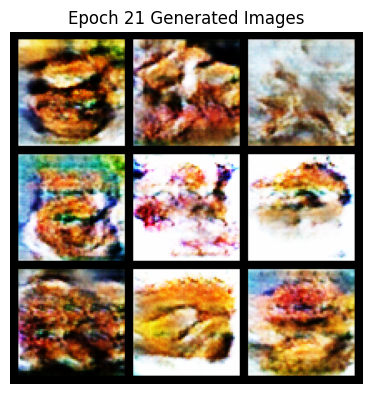

  4%|▍         | 22/500 [23:16<8:05:46, 60.97s/it]

Discriminator Loss EPOCH 22: 4087.9723
Generator Loss EPOCH 22: 4.8101


  5%|▍         | 23/500 [24:16<8:01:34, 60.57s/it]

Discriminator Loss EPOCH 23: 3827.8273
Generator Loss EPOCH 23: 4.8702


  5%|▍         | 24/500 [25:16<7:59:06, 60.39s/it]

Discriminator Loss EPOCH 24: 3550.8957
Generator Loss EPOCH 24: 5.1322


  5%|▌         | 25/500 [26:16<7:56:25, 60.18s/it]

Discriminator Loss EPOCH 25: 3200.3913
Generator Loss EPOCH 25: 4.9307


  5%|▌         | 26/500 [27:15<7:54:19, 60.04s/it]

Discriminator Loss EPOCH 26: 3879.8332
Generator Loss EPOCH 26: 4.9596


  5%|▌         | 27/500 [28:15<7:52:19, 59.91s/it]

Discriminator Loss EPOCH 27: 3081.5991
Generator Loss EPOCH 27: 4.8043


  6%|▌         | 28/500 [29:14<7:50:18, 59.79s/it]

Discriminator Loss EPOCH 28: 3006.5190
Generator Loss EPOCH 28: 4.9448


  6%|▌         | 29/500 [30:15<7:50:52, 59.98s/it]

Discriminator Loss EPOCH 29: 3175.6194
Generator Loss EPOCH 29: 5.2250


  6%|▌         | 30/500 [31:15<7:51:28, 60.19s/it]

Discriminator Loss EPOCH 30: 3074.5564
Generator Loss EPOCH 30: 5.3387


  6%|▌         | 31/500 [32:16<7:51:37, 60.34s/it]

Discriminator Loss EPOCH 31: 2846.3937
Generator Loss EPOCH 31: 5.2007


  6%|▋         | 32/500 [33:17<7:51:48, 60.49s/it]

Discriminator Loss EPOCH 32: 2672.8389
Generator Loss EPOCH 32: 5.4685


  7%|▋         | 33/500 [34:17<7:49:52, 60.37s/it]

Discriminator Loss EPOCH 33: 3435.7538
Generator Loss EPOCH 33: 5.2353


  7%|▋         | 34/500 [35:18<7:50:52, 60.63s/it]

Discriminator Loss EPOCH 34: 2147.5841
Generator Loss EPOCH 34: 5.0645


  7%|▋         | 35/500 [36:20<7:51:49, 60.88s/it]

Discriminator Loss EPOCH 35: 2486.8915
Generator Loss EPOCH 35: 5.5238


  7%|▋         | 36/500 [37:21<7:51:11, 60.93s/it]

Discriminator Loss EPOCH 36: 2955.6355
Generator Loss EPOCH 36: 5.2762


  7%|▋         | 37/500 [38:21<7:48:17, 60.69s/it]

Discriminator Loss EPOCH 37: 2293.6549
Generator Loss EPOCH 37: 5.4352


  8%|▊         | 38/500 [39:21<7:45:38, 60.47s/it]

Discriminator Loss EPOCH 38: 2799.2091
Generator Loss EPOCH 38: 5.6335


  8%|▊         | 39/500 [40:20<7:42:20, 60.18s/it]

Discriminator Loss EPOCH 39: 2802.1285
Generator Loss EPOCH 39: 4.9296


  8%|▊         | 40/500 [41:19<7:38:26, 59.80s/it]

Discriminator Loss EPOCH 40: 2276.3111
Generator Loss EPOCH 40: 5.1529


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 41: 3171.2453
Generator Loss EPOCH 41: 5.1344


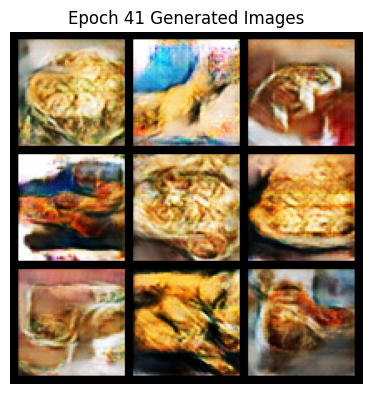

  8%|▊         | 42/500 [43:18<7:34:04, 59.49s/it]

Discriminator Loss EPOCH 42: 3121.0229
Generator Loss EPOCH 42: 5.0252


  9%|▊         | 43/500 [44:17<7:32:00, 59.34s/it]

Discriminator Loss EPOCH 43: 1400.0901
Generator Loss EPOCH 43: 5.1665


  9%|▉         | 44/500 [45:16<7:29:53, 59.20s/it]

Discriminator Loss EPOCH 44: 2843.7688
Generator Loss EPOCH 44: 5.3521


  9%|▉         | 45/500 [46:14<7:27:53, 59.06s/it]

Discriminator Loss EPOCH 45: 3650.0876
Generator Loss EPOCH 45: 5.1326


  9%|▉         | 46/500 [47:13<7:26:50, 59.05s/it]

Discriminator Loss EPOCH 46: 1705.3373
Generator Loss EPOCH 46: 4.8420


  9%|▉         | 47/500 [48:12<7:25:17, 58.98s/it]

Discriminator Loss EPOCH 47: 3056.2134
Generator Loss EPOCH 47: 5.1253


 10%|▉         | 48/500 [49:12<7:26:33, 59.28s/it]

Discriminator Loss EPOCH 48: 1788.4321
Generator Loss EPOCH 48: 5.1472


 10%|▉         | 49/500 [50:12<7:26:40, 59.42s/it]

Discriminator Loss EPOCH 49: 2288.7335
Generator Loss EPOCH 49: 5.0611


 10%|█         | 50/500 [51:11<7:24:41, 59.29s/it]

Discriminator Loss EPOCH 50: 1695.5785
Generator Loss EPOCH 50: 5.0164


 10%|█         | 51/500 [52:10<7:23:22, 59.25s/it]

Discriminator Loss EPOCH 51: 3715.9004
Generator Loss EPOCH 51: 4.8723


 10%|█         | 52/500 [53:09<7:21:21, 59.11s/it]

Discriminator Loss EPOCH 52: 3282.8915
Generator Loss EPOCH 52: 5.1483


 11%|█         | 53/500 [54:10<7:23:59, 59.60s/it]

Discriminator Loss EPOCH 53: 1480.9264
Generator Loss EPOCH 53: 4.7216


 11%|█         | 54/500 [55:11<7:26:23, 60.05s/it]

Discriminator Loss EPOCH 54: 2704.7239
Generator Loss EPOCH 54: 4.8918


 11%|█         | 55/500 [56:13<7:30:00, 60.68s/it]

Discriminator Loss EPOCH 55: 1654.4781
Generator Loss EPOCH 55: 5.1832


 11%|█         | 56/500 [57:16<7:33:47, 61.32s/it]

Discriminator Loss EPOCH 56: 3368.6634
Generator Loss EPOCH 56: 5.0163


 11%|█▏        | 57/500 [58:15<7:28:46, 60.78s/it]

Discriminator Loss EPOCH 57: 1752.2430
Generator Loss EPOCH 57: 4.6902


 12%|█▏        | 58/500 [59:15<7:26:04, 60.55s/it]

Discriminator Loss EPOCH 58: 692.1964
Generator Loss EPOCH 58: 5.0079


 12%|█▏        | 59/500 [1:00:15<7:22:39, 60.22s/it]

Discriminator Loss EPOCH 59: 4063.3910
Generator Loss EPOCH 59: 5.4856


 12%|█▏        | 60/500 [1:01:14<7:18:37, 59.81s/it]

Discriminator Loss EPOCH 60: 1682.5899
Generator Loss EPOCH 60: 4.8835


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Discriminator Loss EPOCH 61: 3522.2081
Generator Loss EPOCH 61: 4.9864


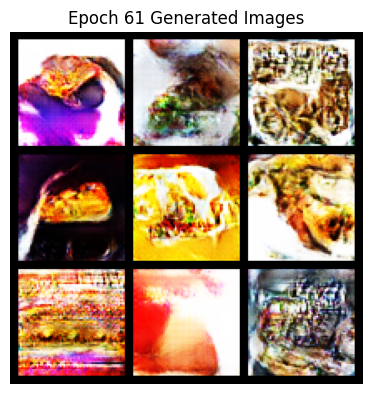

 12%|█▏        | 62/500 [1:03:12<7:14:25, 59.51s/it]

Discriminator Loss EPOCH 62: 2144.7122
Generator Loss EPOCH 62: 5.0904


 13%|█▎        | 63/500 [1:04:11<7:11:49, 59.29s/it]

Discriminator Loss EPOCH 63: 1552.5372
Generator Loss EPOCH 63: 5.0905


 13%|█▎        | 64/500 [1:05:10<7:11:11, 59.34s/it]

Discriminator Loss EPOCH 64: 2125.2844
Generator Loss EPOCH 64: 5.2570


 13%|█▎        | 65/500 [1:06:09<7:09:04, 59.18s/it]

Discriminator Loss EPOCH 65: 1534.9247
Generator Loss EPOCH 65: 5.1079


 13%|█▎        | 66/500 [1:07:08<7:07:30, 59.10s/it]

Discriminator Loss EPOCH 66: 917.1346
Generator Loss EPOCH 66: 5.3338


 13%|█▎        | 67/500 [1:08:07<7:06:04, 59.04s/it]

Discriminator Loss EPOCH 67: 3848.0345
Generator Loss EPOCH 67: 5.5439


 14%|█▎        | 68/500 [1:09:06<7:05:18, 59.07s/it]

Discriminator Loss EPOCH 68: 805.6719
Generator Loss EPOCH 68: 4.9457


 14%|█▍        | 69/500 [1:10:06<7:07:37, 59.53s/it]

Discriminator Loss EPOCH 69: 508.3475
Generator Loss EPOCH 69: 5.1670


 14%|█▍        | 70/500 [1:11:07<7:08:10, 59.75s/it]

Discriminator Loss EPOCH 70: 8298.7852
Generator Loss EPOCH 70: 5.1915


 14%|█▍        | 71/500 [1:12:05<7:04:39, 59.39s/it]

Discriminator Loss EPOCH 71: 1483.2588
Generator Loss EPOCH 71: 4.8503


 14%|█▍        | 72/500 [1:13:04<7:02:41, 59.26s/it]

Discriminator Loss EPOCH 72: 2850.8959
Generator Loss EPOCH 72: 4.9101


 15%|█▍        | 73/500 [1:14:03<7:00:53, 59.14s/it]

Discriminator Loss EPOCH 73: 2028.5079
Generator Loss EPOCH 73: 4.7557


 15%|█▍        | 74/500 [1:15:02<7:00:03, 59.16s/it]

Discriminator Loss EPOCH 74: 2802.2851
Generator Loss EPOCH 74: 5.0580


 15%|█▌        | 75/500 [1:16:01<6:58:04, 59.02s/it]

Discriminator Loss EPOCH 75: 2585.2933
Generator Loss EPOCH 75: 5.0185


 15%|█▌        | 76/500 [1:17:00<6:56:29, 58.94s/it]

Discriminator Loss EPOCH 76: 843.2574
Generator Loss EPOCH 76: 4.8965


 15%|█▌        | 77/500 [1:17:59<6:55:26, 58.93s/it]

Discriminator Loss EPOCH 77: 670.5551
Generator Loss EPOCH 77: 5.0708


 16%|█▌        | 78/500 [1:18:58<6:54:46, 58.97s/it]

Discriminator Loss EPOCH 78: 624.7442
Generator Loss EPOCH 78: 5.1946


 16%|█▌        | 79/500 [1:19:56<6:53:18, 58.90s/it]

Discriminator Loss EPOCH 79: 7401.5588
Generator Loss EPOCH 79: 4.4001


 16%|█▌        | 80/500 [1:20:55<6:52:07, 58.87s/it]

Discriminator Loss EPOCH 80: 2787.5068
Generator Loss EPOCH 80: 5.4177


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


Discriminator Loss EPOCH 81: 1500.6308
Generator Loss EPOCH 81: 4.7760


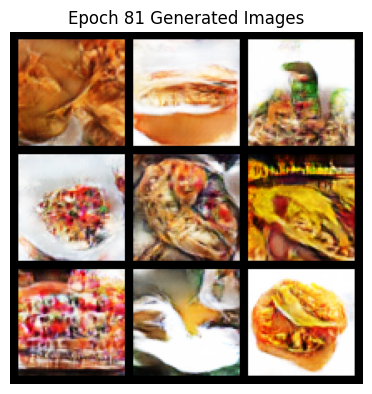

 16%|█▋        | 82/500 [1:22:53<6:50:15, 58.89s/it]

Discriminator Loss EPOCH 82: 751.7581
Generator Loss EPOCH 82: 4.8504


 17%|█▋        | 83/500 [1:23:52<6:49:06, 58.86s/it]

Discriminator Loss EPOCH 83: 472.0911
Generator Loss EPOCH 83: 5.0290


 17%|█▋        | 84/500 [1:24:51<6:48:51, 58.97s/it]

Discriminator Loss EPOCH 84: 3600.4874
Generator Loss EPOCH 84: 4.8543


 17%|█▋        | 85/500 [1:25:51<6:48:49, 59.11s/it]

Discriminator Loss EPOCH 85: 2088.8288
Generator Loss EPOCH 85: 5.0249


 17%|█▋        | 86/500 [1:26:50<6:49:05, 59.29s/it]

Discriminator Loss EPOCH 86: 455.5320
Generator Loss EPOCH 86: 5.1724


 17%|█▋        | 87/500 [1:27:50<6:48:48, 59.39s/it]

Discriminator Loss EPOCH 87: 3078.0437
Generator Loss EPOCH 87: 5.2280


 18%|█▊        | 88/500 [1:28:50<6:49:24, 59.62s/it]

Discriminator Loss EPOCH 88: 2381.3488
Generator Loss EPOCH 88: 5.3004


 18%|█▊        | 89/500 [1:29:50<6:48:21, 59.62s/it]

Discriminator Loss EPOCH 89: 764.8775
Generator Loss EPOCH 89: 5.0069


 18%|█▊        | 90/500 [1:30:49<6:46:39, 59.51s/it]

Discriminator Loss EPOCH 90: 2131.2751
Generator Loss EPOCH 90: 5.3736


 18%|█▊        | 91/500 [1:31:48<6:45:16, 59.45s/it]

Discriminator Loss EPOCH 91: 1709.4098
Generator Loss EPOCH 91: 5.4584


 18%|█▊        | 92/500 [1:32:47<6:43:02, 59.27s/it]

Discriminator Loss EPOCH 92: 646.8688
Generator Loss EPOCH 92: 5.3073


 19%|█▊        | 93/500 [1:33:46<6:41:57, 59.26s/it]

Discriminator Loss EPOCH 93: 2013.2692
Generator Loss EPOCH 93: 5.5701


 19%|█▉        | 94/500 [1:34:46<6:40:55, 59.25s/it]

Discriminator Loss EPOCH 94: 1391.6437
Generator Loss EPOCH 94: 5.6845


 19%|█▉        | 95/500 [1:35:45<6:39:21, 59.16s/it]

Discriminator Loss EPOCH 95: 3837.2778
Generator Loss EPOCH 95: 5.3982


 19%|█▉        | 96/500 [1:36:43<6:37:36, 59.05s/it]

Discriminator Loss EPOCH 96: 1079.7481
Generator Loss EPOCH 96: 5.0427


 19%|█▉        | 97/500 [1:37:43<6:38:15, 59.29s/it]

Discriminator Loss EPOCH 97: 2861.5696
Generator Loss EPOCH 97: 4.7951


 20%|█▉        | 98/500 [1:38:43<6:38:16, 59.44s/it]

Discriminator Loss EPOCH 98: 665.5506
Generator Loss EPOCH 98: 5.1713


 20%|█▉        | 99/500 [1:39:42<6:36:17, 59.29s/it]

Discriminator Loss EPOCH 99: 351.7954
Generator Loss EPOCH 99: 5.3859


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Discriminator Loss EPOCH 100: 305.2415
Generator Loss EPOCH 100: 5.5538


 20%|██        | 100/500 [1:40:41<6:35:22, 59.31s/it]

Checkpoint saved at epoch 99


100%|██████████| 118/118 [00:59<00:00,  1.98it/s]


Discriminator Loss EPOCH 101: 4266.1346
Generator Loss EPOCH 101: 5.6995


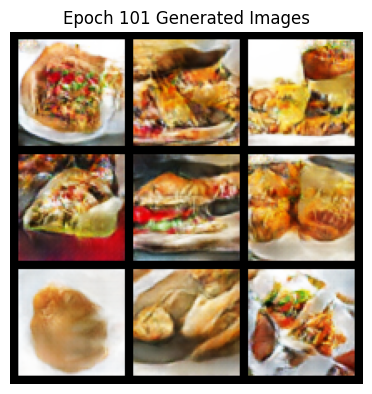

 20%|██        | 102/500 [1:42:40<6:33:32, 59.33s/it]

Discriminator Loss EPOCH 102: 783.6806
Generator Loss EPOCH 102: 5.3123


 21%|██        | 103/500 [1:43:39<6:32:06, 59.26s/it]

Discriminator Loss EPOCH 103: 1029.4201
Generator Loss EPOCH 103: 5.4970


 21%|██        | 104/500 [1:44:39<6:31:19, 59.29s/it]

Discriminator Loss EPOCH 104: 4406.9436
Generator Loss EPOCH 104: 5.5956


 21%|██        | 105/500 [1:45:38<6:30:47, 59.36s/it]

Discriminator Loss EPOCH 105: 612.7336
Generator Loss EPOCH 105: 5.0541


 21%|██        | 106/500 [1:46:37<6:29:58, 59.39s/it]

Discriminator Loss EPOCH 106: 1963.6210
Generator Loss EPOCH 106: 5.2730


 21%|██▏       | 107/500 [1:47:36<6:27:56, 59.23s/it]

Discriminator Loss EPOCH 107: 597.9122
Generator Loss EPOCH 107: 5.3918


 22%|██▏       | 108/500 [1:48:36<6:27:46, 59.35s/it]

Discriminator Loss EPOCH 108: 321.0597
Generator Loss EPOCH 108: 5.5093


 22%|██▏       | 109/500 [1:49:35<6:26:57, 59.38s/it]

Discriminator Loss EPOCH 109: 341.3279
Generator Loss EPOCH 109: 5.7930


 22%|██▏       | 110/500 [1:50:36<6:28:36, 59.79s/it]

Discriminator Loss EPOCH 110: 4588.7044
Generator Loss EPOCH 110: 6.0742


 22%|██▏       | 111/500 [1:51:36<6:27:16, 59.73s/it]

Discriminator Loss EPOCH 111: 2717.9001
Generator Loss EPOCH 111: 5.5498


 22%|██▏       | 112/500 [1:52:35<6:25:14, 59.57s/it]

Discriminator Loss EPOCH 112: 1334.2306
Generator Loss EPOCH 112: 5.1227


 23%|██▎       | 113/500 [1:53:34<6:23:51, 59.51s/it]

Discriminator Loss EPOCH 113: 648.3696
Generator Loss EPOCH 113: 5.2181


 23%|██▎       | 114/500 [1:54:34<6:23:03, 59.54s/it]

Discriminator Loss EPOCH 114: 417.3505
Generator Loss EPOCH 114: 5.4761


 23%|██▎       | 115/500 [1:55:33<6:21:34, 59.47s/it]

Discriminator Loss EPOCH 115: 301.5054
Generator Loss EPOCH 115: 5.6991


 23%|██▎       | 116/500 [1:56:32<6:20:07, 59.39s/it]

Discriminator Loss EPOCH 116: 4888.5715
Generator Loss EPOCH 116: 5.9707


 23%|██▎       | 117/500 [1:57:34<6:23:12, 60.03s/it]

Discriminator Loss EPOCH 117: 849.7349
Generator Loss EPOCH 117: 5.2989


 24%|██▎       | 118/500 [1:58:34<6:22:14, 60.04s/it]

Discriminator Loss EPOCH 118: 1595.6757
Generator Loss EPOCH 118: 5.4453


 24%|██▍       | 119/500 [1:59:34<6:21:45, 60.12s/it]

Discriminator Loss EPOCH 119: 381.7348
Generator Loss EPOCH 119: 5.4943


 24%|██▍       | 120/500 [2:00:35<6:22:02, 60.32s/it]

Discriminator Loss EPOCH 120: 308.9707
Generator Loss EPOCH 120: 5.7040


100%|██████████| 118/118 [01:00<00:00,  1.97it/s]


Discriminator Loss EPOCH 121: 3452.8585
Generator Loss EPOCH 121: 6.3843


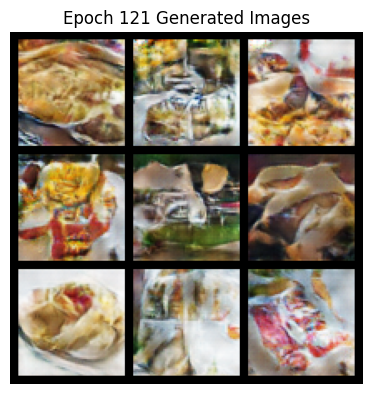

 24%|██▍       | 122/500 [2:02:34<6:16:57, 59.83s/it]

Discriminator Loss EPOCH 122: 1444.7334
Generator Loss EPOCH 122: 5.7306


 25%|██▍       | 123/500 [2:03:33<6:14:23, 59.58s/it]

Discriminator Loss EPOCH 123: 2508.1276
Generator Loss EPOCH 123: 5.7034


 25%|██▍       | 124/500 [2:04:32<6:11:32, 59.29s/it]

Discriminator Loss EPOCH 124: 1541.7124
Generator Loss EPOCH 124: 5.2563


 25%|██▌       | 125/500 [2:05:31<6:09:54, 59.19s/it]

Discriminator Loss EPOCH 125: 535.3947
Generator Loss EPOCH 125: 5.5607


 25%|██▌       | 126/500 [2:06:30<6:08:40, 59.15s/it]

Discriminator Loss EPOCH 126: 333.1688
Generator Loss EPOCH 126: 5.6021


 25%|██▌       | 127/500 [2:07:29<6:07:21, 59.09s/it]

Discriminator Loss EPOCH 127: 344.0632
Generator Loss EPOCH 127: 5.9920


 26%|██▌       | 128/500 [2:08:27<6:05:23, 58.93s/it]

Discriminator Loss EPOCH 128: 4021.0253
Generator Loss EPOCH 128: 5.3596


 26%|██▌       | 129/500 [2:09:26<6:04:21, 58.93s/it]

Discriminator Loss EPOCH 129: 650.2297
Generator Loss EPOCH 129: 5.6448


 26%|██▌       | 130/500 [2:10:25<6:02:55, 58.85s/it]

Discriminator Loss EPOCH 130: 327.9333
Generator Loss EPOCH 130: 5.7535


 26%|██▌       | 131/500 [2:11:23<6:01:15, 58.74s/it]

Discriminator Loss EPOCH 131: 3970.0695
Generator Loss EPOCH 131: 6.3481


 26%|██▋       | 132/500 [2:12:22<6:00:15, 58.74s/it]

Discriminator Loss EPOCH 132: 1512.8770
Generator Loss EPOCH 132: 5.5777


 27%|██▋       | 133/500 [2:13:21<5:59:18, 58.74s/it]

Discriminator Loss EPOCH 133: 481.5970
Generator Loss EPOCH 133: 5.4999


 27%|██▋       | 134/500 [2:14:20<5:58:54, 58.84s/it]

Discriminator Loss EPOCH 134: 398.8766
Generator Loss EPOCH 134: 5.8101


 27%|██▋       | 135/500 [2:15:18<5:57:00, 58.69s/it]

Discriminator Loss EPOCH 135: 3548.7658
Generator Loss EPOCH 135: 5.9246


 27%|██▋       | 136/500 [2:16:17<5:55:50, 58.65s/it]

Discriminator Loss EPOCH 136: 491.0278
Generator Loss EPOCH 136: 5.6312


 27%|██▋       | 137/500 [2:17:16<5:55:01, 58.68s/it]

Discriminator Loss EPOCH 137: 1699.2182
Generator Loss EPOCH 137: 5.5434


 28%|██▊       | 138/500 [2:18:15<5:54:50, 58.81s/it]

Discriminator Loss EPOCH 138: 1188.9325
Generator Loss EPOCH 138: 5.8353


 28%|██▊       | 139/500 [2:19:14<5:55:21, 59.06s/it]

Discriminator Loss EPOCH 139: 456.9370
Generator Loss EPOCH 139: 5.8680


 28%|██▊       | 140/500 [2:20:13<5:54:24, 59.07s/it]

Discriminator Loss EPOCH 140: 302.2006
Generator Loss EPOCH 140: 6.0672


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 141: 387.9600
Generator Loss EPOCH 141: 6.4231


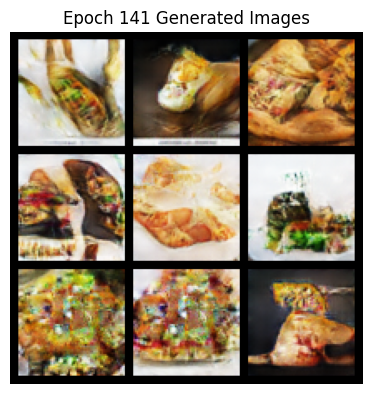

 28%|██▊       | 142/500 [2:22:13<5:54:10, 59.36s/it]

Discriminator Loss EPOCH 142: 3478.6623
Generator Loss EPOCH 142: 6.4273


 29%|██▊       | 143/500 [2:23:12<5:53:00, 59.33s/it]

Discriminator Loss EPOCH 143: 545.3727
Generator Loss EPOCH 143: 5.7331


 29%|██▉       | 144/500 [2:24:12<5:54:20, 59.72s/it]

Discriminator Loss EPOCH 144: 422.1020
Generator Loss EPOCH 144: 6.0420


 29%|██▉       | 145/500 [2:25:13<5:54:59, 60.00s/it]

Discriminator Loss EPOCH 145: 336.6860
Generator Loss EPOCH 145: 6.1745


 29%|██▉       | 146/500 [2:26:13<5:54:38, 60.11s/it]

Discriminator Loss EPOCH 146: 3731.6378
Generator Loss EPOCH 146: 6.7935


 29%|██▉       | 147/500 [2:27:13<5:52:47, 59.96s/it]

Discriminator Loss EPOCH 147: 1532.7751
Generator Loss EPOCH 147: 5.8727


 30%|██▉       | 148/500 [2:28:13<5:51:19, 59.89s/it]

Discriminator Loss EPOCH 148: 1055.9329
Generator Loss EPOCH 148: 5.8429


 30%|██▉       | 149/500 [2:29:12<5:48:50, 59.63s/it]

Discriminator Loss EPOCH 149: 800.0254
Generator Loss EPOCH 149: 5.6654


 30%|███       | 150/500 [2:30:11<5:46:36, 59.42s/it]

Discriminator Loss EPOCH 150: 1783.3945
Generator Loss EPOCH 150: 5.6908


 30%|███       | 151/500 [2:31:13<5:50:22, 60.24s/it]

Discriminator Loss EPOCH 151: 466.4907
Generator Loss EPOCH 151: 5.7646


 30%|███       | 152/500 [2:32:14<5:50:03, 60.36s/it]

Discriminator Loss EPOCH 152: 1984.6481
Generator Loss EPOCH 152: 5.6507


 31%|███       | 153/500 [2:33:12<5:46:19, 59.88s/it]

Discriminator Loss EPOCH 153: 392.5137
Generator Loss EPOCH 153: 5.7160


 31%|███       | 154/500 [2:34:11<5:43:20, 59.54s/it]

Discriminator Loss EPOCH 154: 829.4408
Generator Loss EPOCH 154: 6.3020


 31%|███       | 155/500 [2:35:10<5:41:14, 59.35s/it]

Discriminator Loss EPOCH 155: 435.5124
Generator Loss EPOCH 155: 6.1049


 31%|███       | 156/500 [2:36:10<5:41:51, 59.63s/it]

Discriminator Loss EPOCH 156: 328.9535
Generator Loss EPOCH 156: 6.1165


 31%|███▏      | 157/500 [2:37:11<5:42:25, 59.90s/it]

Discriminator Loss EPOCH 157: 5011.7916
Generator Loss EPOCH 157: 6.8425


 32%|███▏      | 158/500 [2:38:11<5:42:16, 60.05s/it]

Discriminator Loss EPOCH 158: 1700.9324
Generator Loss EPOCH 158: 6.0567


 32%|███▏      | 159/500 [2:39:10<5:39:53, 59.80s/it]

Discriminator Loss EPOCH 159: 1302.6069
Generator Loss EPOCH 159: 5.7158


 32%|███▏      | 160/500 [2:40:10<5:38:28, 59.73s/it]

Discriminator Loss EPOCH 160: 512.0666
Generator Loss EPOCH 160: 6.2467


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 161: 375.1927
Generator Loss EPOCH 161: 6.0370


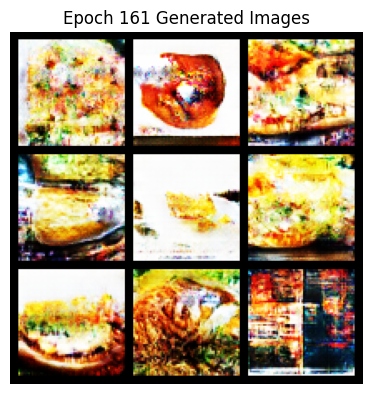

 32%|███▏      | 162/500 [2:42:09<5:35:06, 59.49s/it]

Discriminator Loss EPOCH 162: 340.3811
Generator Loss EPOCH 162: 6.1550


 33%|███▎      | 163/500 [2:43:07<5:32:36, 59.22s/it]

Discriminator Loss EPOCH 163: 8152.6544
Generator Loss EPOCH 163: 6.6467


 33%|███▎      | 164/500 [2:44:06<5:31:33, 59.21s/it]

Discriminator Loss EPOCH 164: 1580.8065
Generator Loss EPOCH 164: 5.6031


 33%|███▎      | 165/500 [2:45:06<5:31:01, 59.29s/it]

Discriminator Loss EPOCH 165: 517.3629
Generator Loss EPOCH 165: 5.6393


 33%|███▎      | 166/500 [2:46:05<5:30:20, 59.34s/it]

Discriminator Loss EPOCH 166: 515.4288
Generator Loss EPOCH 166: 5.9168


 33%|███▎      | 167/500 [2:47:05<5:29:29, 59.37s/it]

Discriminator Loss EPOCH 167: 3112.2842
Generator Loss EPOCH 167: 5.8177


 34%|███▎      | 168/500 [2:48:05<5:30:24, 59.71s/it]

Discriminator Loss EPOCH 168: 462.5868
Generator Loss EPOCH 168: 5.7392


 34%|███▍      | 169/500 [2:49:05<5:29:18, 59.69s/it]

Discriminator Loss EPOCH 169: 1158.8789
Generator Loss EPOCH 169: 5.9206


 34%|███▍      | 170/500 [2:50:04<5:28:02, 59.64s/it]

Discriminator Loss EPOCH 170: 1174.1142
Generator Loss EPOCH 170: 5.8198


 34%|███▍      | 171/500 [2:51:04<5:27:15, 59.68s/it]

Discriminator Loss EPOCH 171: 1218.4940
Generator Loss EPOCH 171: 6.1281


 34%|███▍      | 172/500 [2:52:04<5:26:07, 59.66s/it]

Discriminator Loss EPOCH 172: 337.8932
Generator Loss EPOCH 172: 6.1530


 35%|███▍      | 173/500 [2:53:04<5:26:55, 59.99s/it]

Discriminator Loss EPOCH 173: 1409.6494
Generator Loss EPOCH 173: 6.4144


 35%|███▍      | 174/500 [2:54:04<5:25:46, 59.96s/it]

Discriminator Loss EPOCH 174: 358.5795
Generator Loss EPOCH 174: 6.0208


 35%|███▌      | 175/500 [2:55:04<5:24:33, 59.92s/it]

Discriminator Loss EPOCH 175: 350.3471
Generator Loss EPOCH 175: 6.5350


 35%|███▌      | 176/500 [2:56:04<5:23:57, 59.99s/it]

Discriminator Loss EPOCH 176: 5375.7134
Generator Loss EPOCH 176: 6.3777


 35%|███▌      | 177/500 [2:57:04<5:22:30, 59.91s/it]

Discriminator Loss EPOCH 177: 484.6800
Generator Loss EPOCH 177: 5.8071


 36%|███▌      | 178/500 [2:58:04<5:20:57, 59.81s/it]

Discriminator Loss EPOCH 178: 374.8776
Generator Loss EPOCH 178: 5.9099


 36%|███▌      | 179/500 [2:59:03<5:19:33, 59.73s/it]

Discriminator Loss EPOCH 179: 409.4201
Generator Loss EPOCH 179: 6.3131


 36%|███▌      | 180/500 [3:00:02<5:17:35, 59.55s/it]

Discriminator Loss EPOCH 180: 286.4087
Generator Loss EPOCH 180: 6.2349


100%|██████████| 118/118 [00:59<00:00,  2.00it/s]


Discriminator Loss EPOCH 181: 2713.9699
Generator Loss EPOCH 181: 6.4654


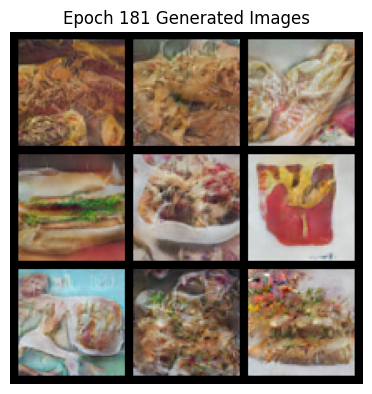

 36%|███▋      | 182/500 [3:02:01<5:14:26, 59.33s/it]

Discriminator Loss EPOCH 182: 612.6077
Generator Loss EPOCH 182: 6.0895


 37%|███▋      | 183/500 [3:03:00<5:13:42, 59.38s/it]

Discriminator Loss EPOCH 183: 374.0655
Generator Loss EPOCH 183: 6.3775


 37%|███▋      | 184/500 [3:04:00<5:12:49, 59.40s/it]

Discriminator Loss EPOCH 184: 2873.8440
Generator Loss EPOCH 184: 7.1604


 37%|███▋      | 185/500 [3:04:59<5:11:48, 59.39s/it]

Discriminator Loss EPOCH 185: 1011.6236
Generator Loss EPOCH 185: 6.0860


 37%|███▋      | 186/500 [3:05:58<5:10:16, 59.29s/it]

Discriminator Loss EPOCH 186: 1355.8000
Generator Loss EPOCH 186: 6.4057


 37%|███▋      | 187/500 [3:06:57<5:08:26, 59.13s/it]

Discriminator Loss EPOCH 187: 668.6081
Generator Loss EPOCH 187: 5.9283


 38%|███▊      | 188/500 [3:07:56<5:07:59, 59.23s/it]

Discriminator Loss EPOCH 188: 356.0229
Generator Loss EPOCH 188: 6.1737


 38%|███▊      | 189/500 [3:08:56<5:08:11, 59.46s/it]

Discriminator Loss EPOCH 189: 349.3066
Generator Loss EPOCH 189: 6.5883


 38%|███▊      | 190/500 [3:09:56<5:08:05, 59.63s/it]

Discriminator Loss EPOCH 190: 1761.3438
Generator Loss EPOCH 190: 6.6120


 38%|███▊      | 191/500 [3:10:56<5:07:07, 59.64s/it]

Discriminator Loss EPOCH 191: 435.8803
Generator Loss EPOCH 191: 6.9892


 38%|███▊      | 192/500 [3:11:55<5:05:53, 59.59s/it]

Discriminator Loss EPOCH 192: 294.0168
Generator Loss EPOCH 192: 6.6308


 39%|███▊      | 193/500 [3:12:59<5:11:55, 60.96s/it]

Discriminator Loss EPOCH 193: 1142.9451
Generator Loss EPOCH 193: 6.9280


 39%|███▉      | 194/500 [3:14:01<5:11:50, 61.15s/it]

Discriminator Loss EPOCH 194: 541.3325
Generator Loss EPOCH 194: 7.1003


 39%|███▉      | 195/500 [3:15:06<5:17:02, 62.37s/it]

Discriminator Loss EPOCH 195: 262.9425
Generator Loss EPOCH 195: 6.6859


 39%|███▉      | 196/500 [3:16:09<5:16:46, 62.52s/it]

Discriminator Loss EPOCH 196: 260.8565
Generator Loss EPOCH 196: 6.7388


 39%|███▉      | 197/500 [3:17:10<5:13:08, 62.01s/it]

Discriminator Loss EPOCH 197: 282.7616
Generator Loss EPOCH 197: 7.3036


 40%|███▉      | 198/500 [3:18:09<5:07:24, 61.07s/it]

Discriminator Loss EPOCH 198: 223.1757
Generator Loss EPOCH 198: 6.7542


 40%|███▉      | 199/500 [3:19:08<5:03:50, 60.57s/it]

Discriminator Loss EPOCH 199: 7215.6287
Generator Loss EPOCH 199: 7.1059


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 200: 566.3932
Generator Loss EPOCH 200: 6.1341


 40%|████      | 200/500 [3:20:08<5:01:20, 60.27s/it]

Checkpoint saved at epoch 199


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 201: 393.3675
Generator Loss EPOCH 201: 6.6080


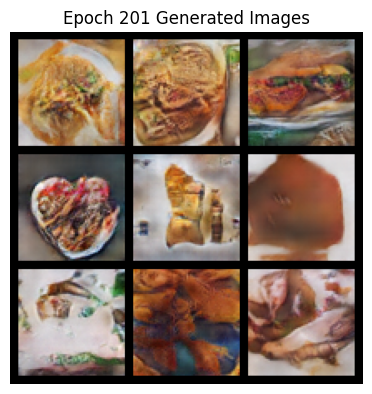

 40%|████      | 202/500 [3:22:06<4:56:39, 59.73s/it]

Discriminator Loss EPOCH 202: 276.2965
Generator Loss EPOCH 202: 6.3584


 41%|████      | 203/500 [3:23:06<4:55:15, 59.65s/it]

Discriminator Loss EPOCH 203: 6143.9550
Generator Loss EPOCH 203: 7.0572


 41%|████      | 204/500 [3:24:05<4:54:03, 59.61s/it]

Discriminator Loss EPOCH 204: 1478.6553
Generator Loss EPOCH 204: 6.0824


 41%|████      | 205/500 [3:25:05<4:53:57, 59.79s/it]

Discriminator Loss EPOCH 205: 438.1262
Generator Loss EPOCH 205: 5.8173


 41%|████      | 206/500 [3:26:06<4:53:22, 59.87s/it]

Discriminator Loss EPOCH 206: 516.6134
Generator Loss EPOCH 206: 6.3637


 41%|████▏     | 207/500 [3:27:05<4:51:44, 59.74s/it]

Discriminator Loss EPOCH 207: 299.6119
Generator Loss EPOCH 207: 6.1409


 42%|████▏     | 208/500 [3:28:05<4:51:12, 59.84s/it]

Discriminator Loss EPOCH 208: 303.8287
Generator Loss EPOCH 208: 6.3270


 42%|████▏     | 209/500 [3:29:06<4:51:56, 60.19s/it]

Discriminator Loss EPOCH 209: 305.0970
Generator Loss EPOCH 209: 7.5838


 42%|████▏     | 210/500 [3:30:07<4:52:26, 60.50s/it]

Discriminator Loss EPOCH 210: 1669.1985
Generator Loss EPOCH 210: 7.4025


 42%|████▏     | 211/500 [3:31:08<4:51:43, 60.56s/it]

Discriminator Loss EPOCH 211: 602.8568
Generator Loss EPOCH 211: 6.5796


 42%|████▏     | 212/500 [3:32:07<4:48:30, 60.11s/it]

Discriminator Loss EPOCH 212: 349.8715
Generator Loss EPOCH 212: 6.5599


 43%|████▎     | 213/500 [3:33:06<4:46:11, 59.83s/it]

Discriminator Loss EPOCH 213: 2486.6963
Generator Loss EPOCH 213: 7.1787


 43%|████▎     | 214/500 [3:34:05<4:43:59, 59.58s/it]

Discriminator Loss EPOCH 214: 430.0522
Generator Loss EPOCH 214: 6.4023


 43%|████▎     | 215/500 [3:35:04<4:42:06, 59.39s/it]

Discriminator Loss EPOCH 215: 290.9989
Generator Loss EPOCH 215: 6.4175


 43%|████▎     | 216/500 [3:36:04<4:41:25, 59.45s/it]

Discriminator Loss EPOCH 216: 234.6545
Generator Loss EPOCH 216: 6.3513


 43%|████▎     | 217/500 [3:37:03<4:40:49, 59.54s/it]

Discriminator Loss EPOCH 217: 201.1593
Generator Loss EPOCH 217: 6.4166


 44%|████▎     | 218/500 [3:38:02<4:38:47, 59.32s/it]

Discriminator Loss EPOCH 218: 184.4655
Generator Loss EPOCH 218: 6.5648


 44%|████▍     | 219/500 [3:39:01<4:36:56, 59.13s/it]

Discriminator Loss EPOCH 219: 4274.6666
Generator Loss EPOCH 219: 7.8989


 44%|████▍     | 220/500 [3:40:00<4:35:30, 59.04s/it]

Discriminator Loss EPOCH 220: 755.1001
Generator Loss EPOCH 220: 6.6974


100%|██████████| 118/118 [00:59<00:00,  1.97it/s]


Discriminator Loss EPOCH 221: 597.7559
Generator Loss EPOCH 221: 6.4082


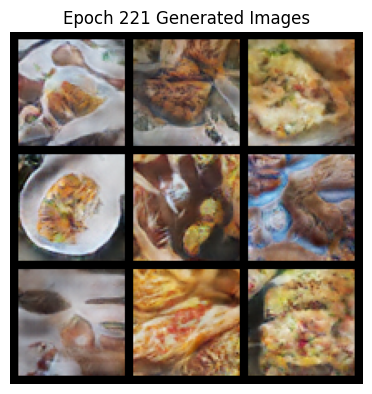

 44%|████▍     | 222/500 [3:42:00<4:35:40, 59.50s/it]

Discriminator Loss EPOCH 222: 266.6365
Generator Loss EPOCH 222: 6.6813


 45%|████▍     | 223/500 [3:42:59<4:35:00, 59.57s/it]

Discriminator Loss EPOCH 223: 1443.3817
Generator Loss EPOCH 223: 7.0098


 45%|████▍     | 224/500 [3:43:59<4:34:04, 59.58s/it]

Discriminator Loss EPOCH 224: 2380.4017
Generator Loss EPOCH 224: 7.1437


 45%|████▌     | 225/500 [3:44:59<4:33:20, 59.64s/it]

Discriminator Loss EPOCH 225: 376.8273
Generator Loss EPOCH 225: 6.7077


 45%|████▌     | 226/500 [3:45:59<4:33:16, 59.84s/it]

Discriminator Loss EPOCH 226: 295.8895
Generator Loss EPOCH 226: 6.7274


 45%|████▌     | 227/500 [3:47:00<4:34:13, 60.27s/it]

Discriminator Loss EPOCH 227: 946.6013
Generator Loss EPOCH 227: 6.8990


 46%|████▌     | 228/500 [3:48:01<4:33:55, 60.43s/it]

Discriminator Loss EPOCH 228: 449.7472
Generator Loss EPOCH 228: 6.3563


 46%|████▌     | 229/500 [3:49:02<4:32:51, 60.41s/it]

Discriminator Loss EPOCH 229: 527.4478
Generator Loss EPOCH 229: 7.5766


 46%|████▌     | 230/500 [3:50:02<4:31:36, 60.36s/it]

Discriminator Loss EPOCH 230: 494.4431
Generator Loss EPOCH 230: 8.1098


 46%|████▌     | 231/500 [3:51:02<4:29:45, 60.17s/it]

Discriminator Loss EPOCH 231: 215.7314
Generator Loss EPOCH 231: 6.6952


 46%|████▋     | 232/500 [3:52:00<4:27:05, 59.80s/it]

Discriminator Loss EPOCH 232: 215.3937
Generator Loss EPOCH 232: 7.5498


 47%|████▋     | 233/500 [3:52:59<4:24:54, 59.53s/it]

Discriminator Loss EPOCH 233: 1459.6474
Generator Loss EPOCH 233: 8.8908


 47%|████▋     | 234/500 [3:53:58<4:22:52, 59.30s/it]

Discriminator Loss EPOCH 234: 273.9906
Generator Loss EPOCH 234: 6.6668


 47%|████▋     | 235/500 [3:54:57<4:21:38, 59.24s/it]

Discriminator Loss EPOCH 235: 199.3570
Generator Loss EPOCH 235: 6.8973


 47%|████▋     | 236/500 [3:55:56<4:20:22, 59.18s/it]

Discriminator Loss EPOCH 236: 286.8078
Generator Loss EPOCH 236: 8.5926


 47%|████▋     | 237/500 [3:56:55<4:19:04, 59.10s/it]

Discriminator Loss EPOCH 237: 4786.1216
Generator Loss EPOCH 237: 8.1874


 48%|████▊     | 238/500 [3:57:54<4:18:06, 59.11s/it]

Discriminator Loss EPOCH 238: 450.0657
Generator Loss EPOCH 238: 6.5764


 48%|████▊     | 239/500 [3:58:53<4:17:01, 59.09s/it]

Discriminator Loss EPOCH 239: 511.4497
Generator Loss EPOCH 239: 7.7212


 48%|████▊     | 240/500 [3:59:53<4:16:15, 59.14s/it]

Discriminator Loss EPOCH 240: 279.7308
Generator Loss EPOCH 240: 6.5635


100%|██████████| 118/118 [00:59<00:00,  2.00it/s]


Discriminator Loss EPOCH 241: 201.9947
Generator Loss EPOCH 241: 7.3129


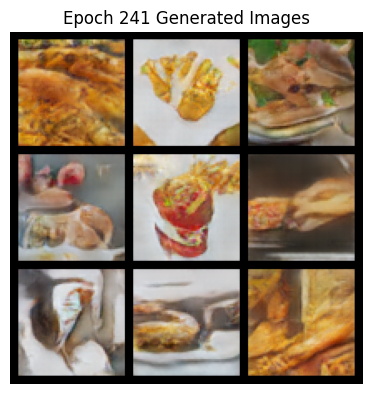

 48%|████▊     | 242/500 [4:01:51<4:14:14, 59.13s/it]

Discriminator Loss EPOCH 242: 184.7113
Generator Loss EPOCH 242: 6.6121


 49%|████▊     | 243/500 [4:02:50<4:12:53, 59.04s/it]

Discriminator Loss EPOCH 243: 186.3209
Generator Loss EPOCH 243: 6.9272


 49%|████▉     | 244/500 [4:03:48<4:10:53, 58.80s/it]

Discriminator Loss EPOCH 244: 215.0412
Generator Loss EPOCH 244: 8.8000


 49%|████▉     | 245/500 [4:04:47<4:10:38, 58.98s/it]

Discriminator Loss EPOCH 245: 184.4817
Generator Loss EPOCH 245: 7.6269


 49%|████▉     | 246/500 [4:05:47<4:10:14, 59.11s/it]

Discriminator Loss EPOCH 246: 9122.3024
Generator Loss EPOCH 246: 8.6866


 49%|████▉     | 247/500 [4:06:45<4:08:39, 58.97s/it]

Discriminator Loss EPOCH 247: 555.6930
Generator Loss EPOCH 247: 6.2574


 50%|████▉     | 248/500 [4:07:44<4:07:23, 58.90s/it]

Discriminator Loss EPOCH 248: 374.5316
Generator Loss EPOCH 248: 6.5584


 50%|████▉     | 249/500 [4:08:43<4:06:00, 58.81s/it]

Discriminator Loss EPOCH 249: 358.9802
Generator Loss EPOCH 249: 7.2759


 50%|█████     | 250/500 [4:09:42<4:05:14, 58.86s/it]

Discriminator Loss EPOCH 250: 234.1758
Generator Loss EPOCH 250: 6.5522


 50%|█████     | 251/500 [4:10:40<4:03:59, 58.79s/it]

Discriminator Loss EPOCH 251: 362.6938
Generator Loss EPOCH 251: 8.0369


 50%|█████     | 252/500 [4:11:39<4:02:40, 58.71s/it]

Discriminator Loss EPOCH 252: 227.7952
Generator Loss EPOCH 252: 6.9847


 51%|█████     | 253/500 [4:12:37<4:01:32, 58.67s/it]

Discriminator Loss EPOCH 253: 170.3089
Generator Loss EPOCH 253: 6.8127


 51%|█████     | 254/500 [4:13:37<4:01:16, 58.85s/it]

Discriminator Loss EPOCH 254: 2561.4873
Generator Loss EPOCH 254: 8.6147


 51%|█████     | 255/500 [4:14:36<4:00:24, 58.88s/it]

Discriminator Loss EPOCH 255: 710.1105
Generator Loss EPOCH 255: 6.9897


 51%|█████     | 256/500 [4:15:34<3:59:06, 58.80s/it]

Discriminator Loss EPOCH 256: 258.0403
Generator Loss EPOCH 256: 6.7519


 51%|█████▏    | 257/500 [4:16:33<3:57:32, 58.65s/it]

Discriminator Loss EPOCH 257: 249.7735
Generator Loss EPOCH 257: 7.9012


 52%|█████▏    | 258/500 [4:17:31<3:56:10, 58.56s/it]

Discriminator Loss EPOCH 258: 212.9728
Generator Loss EPOCH 258: 7.5890


 52%|█████▏    | 259/500 [4:18:30<3:55:22, 58.60s/it]

Discriminator Loss EPOCH 259: 167.4749
Generator Loss EPOCH 259: 6.9771


 52%|█████▏    | 260/500 [4:19:28<3:54:14, 58.56s/it]

Discriminator Loss EPOCH 260: 172.6136
Generator Loss EPOCH 260: 8.6295


100%|██████████| 118/118 [00:59<00:00,  2.00it/s]


Discriminator Loss EPOCH 261: 185.3704
Generator Loss EPOCH 261: 7.6521


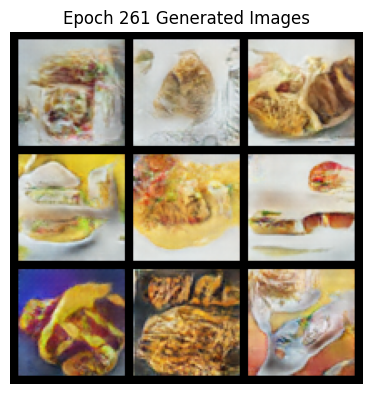

 52%|█████▏    | 262/500 [4:21:26<3:52:38, 58.65s/it]

Discriminator Loss EPOCH 262: 6040.7700
Generator Loss EPOCH 262: 7.7827


 53%|█████▎    | 263/500 [4:22:25<3:52:01, 58.74s/it]

Discriminator Loss EPOCH 263: 478.6193
Generator Loss EPOCH 263: 6.6723


 53%|█████▎    | 264/500 [4:23:24<3:51:46, 58.92s/it]

Discriminator Loss EPOCH 264: 277.0146
Generator Loss EPOCH 264: 6.5769


 53%|█████▎    | 265/500 [4:24:23<3:50:38, 58.89s/it]

Discriminator Loss EPOCH 265: 4330.9319
Generator Loss EPOCH 265: 7.2047


 53%|█████▎    | 266/500 [4:25:21<3:49:16, 58.79s/it]

Discriminator Loss EPOCH 266: 376.8480
Generator Loss EPOCH 266: 7.0321


 53%|█████▎    | 267/500 [4:26:20<3:48:02, 58.72s/it]

Discriminator Loss EPOCH 267: 286.5683
Generator Loss EPOCH 267: 7.0257


 54%|█████▎    | 268/500 [4:27:19<3:47:13, 58.76s/it]

Discriminator Loss EPOCH 268: 246.7205
Generator Loss EPOCH 268: 7.0615


 54%|█████▍    | 269/500 [4:28:17<3:46:04, 58.72s/it]

Discriminator Loss EPOCH 269: 257.2962
Generator Loss EPOCH 269: 6.9443


 54%|█████▍    | 270/500 [4:29:16<3:45:06, 58.72s/it]

Discriminator Loss EPOCH 270: 325.9970
Generator Loss EPOCH 270: 8.0669


 54%|█████▍    | 271/500 [4:30:17<3:45:59, 59.21s/it]

Discriminator Loss EPOCH 271: 183.5333
Generator Loss EPOCH 271: 7.4512


 54%|█████▍    | 272/500 [4:31:15<3:44:32, 59.09s/it]

Discriminator Loss EPOCH 272: 178.3793
Generator Loss EPOCH 272: 6.8703


 55%|█████▍    | 273/500 [4:32:14<3:43:27, 59.06s/it]

Discriminator Loss EPOCH 273: 3142.8815
Generator Loss EPOCH 273: 7.6752


 55%|█████▍    | 274/500 [4:33:13<3:41:33, 58.82s/it]

Discriminator Loss EPOCH 274: 313.8028
Generator Loss EPOCH 274: 7.0330


 55%|█████▌    | 275/500 [4:34:11<3:40:01, 58.67s/it]

Discriminator Loss EPOCH 275: 205.4573
Generator Loss EPOCH 275: 6.8979


 55%|█████▌    | 276/500 [4:35:10<3:39:42, 58.85s/it]

Discriminator Loss EPOCH 276: 217.7225
Generator Loss EPOCH 276: 8.2520


 55%|█████▌    | 277/500 [4:36:12<3:41:29, 59.59s/it]

Discriminator Loss EPOCH 277: 193.4615
Generator Loss EPOCH 277: 7.6794


 56%|█████▌    | 278/500 [4:37:12<3:41:44, 59.93s/it]

Discriminator Loss EPOCH 278: 157.1400
Generator Loss EPOCH 278: 7.0044


 56%|█████▌    | 279/500 [4:38:13<3:41:41, 60.19s/it]

Discriminator Loss EPOCH 279: 141.5728
Generator Loss EPOCH 279: 7.6446


 56%|█████▌    | 280/500 [4:39:14<3:41:26, 60.39s/it]

Discriminator Loss EPOCH 280: 124.0957
Generator Loss EPOCH 280: 7.2727


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Discriminator Loss EPOCH 281: 133.8737
Generator Loss EPOCH 281: 8.2916


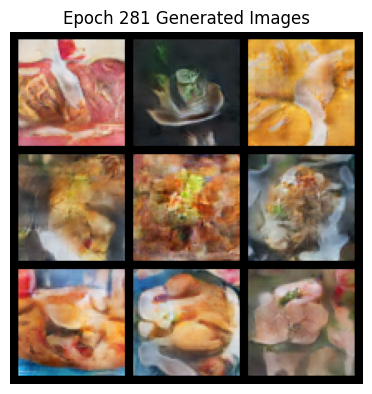

 56%|█████▋    | 282/500 [4:41:11<3:36:19, 59.54s/it]

Discriminator Loss EPOCH 282: 5412.5552
Generator Loss EPOCH 282: 8.9148


 57%|█████▋    | 283/500 [4:42:10<3:34:37, 59.35s/it]

Discriminator Loss EPOCH 283: 429.3328
Generator Loss EPOCH 283: 8.2208


 57%|█████▋    | 284/500 [4:43:09<3:32:57, 59.16s/it]

Discriminator Loss EPOCH 284: 284.4514
Generator Loss EPOCH 284: 7.5153


 57%|█████▋    | 285/500 [4:44:08<3:31:42, 59.08s/it]

Discriminator Loss EPOCH 285: 1352.9799
Generator Loss EPOCH 285: 7.8975


 57%|█████▋    | 286/500 [4:45:07<3:31:00, 59.16s/it]

Discriminator Loss EPOCH 286: 387.3253
Generator Loss EPOCH 286: 7.3928


 57%|█████▋    | 287/500 [4:46:06<3:30:04, 59.18s/it]

Discriminator Loss EPOCH 287: 178.9208
Generator Loss EPOCH 287: 6.9545


 58%|█████▊    | 288/500 [4:47:06<3:29:07, 59.19s/it]

Discriminator Loss EPOCH 288: 177.1942
Generator Loss EPOCH 288: 7.2545


 58%|█████▊    | 289/500 [4:48:05<3:27:48, 59.09s/it]

Discriminator Loss EPOCH 289: 2114.9657
Generator Loss EPOCH 289: 7.7971


 58%|█████▊    | 290/500 [4:49:03<3:26:36, 59.03s/it]

Discriminator Loss EPOCH 290: 261.1653
Generator Loss EPOCH 290: 7.3344


 58%|█████▊    | 291/500 [4:50:02<3:24:55, 58.83s/it]

Discriminator Loss EPOCH 291: 221.1767
Generator Loss EPOCH 291: 7.3067


 58%|█████▊    | 292/500 [4:51:00<3:23:49, 58.80s/it]

Discriminator Loss EPOCH 292: 1855.0358
Generator Loss EPOCH 292: 7.7649


 59%|█████▊    | 293/500 [4:52:00<3:23:07, 58.88s/it]

Discriminator Loss EPOCH 293: 247.6041
Generator Loss EPOCH 293: 7.1388


 59%|█████▉    | 294/500 [4:52:58<3:21:34, 58.71s/it]

Discriminator Loss EPOCH 294: 185.4077
Generator Loss EPOCH 294: 8.4007


 59%|█████▉    | 295/500 [4:53:57<3:20:31, 58.69s/it]

Discriminator Loss EPOCH 295: 146.2223
Generator Loss EPOCH 295: 6.8636


 59%|█████▉    | 296/500 [4:54:55<3:19:36, 58.71s/it]

Discriminator Loss EPOCH 296: 152.3082
Generator Loss EPOCH 296: 7.6831


 59%|█████▉    | 297/500 [4:55:54<3:18:22, 58.63s/it]

Discriminator Loss EPOCH 297: 145.7181
Generator Loss EPOCH 297: 8.7418


 60%|█████▉    | 298/500 [4:56:52<3:17:20, 58.62s/it]

Discriminator Loss EPOCH 298: 123.7340
Generator Loss EPOCH 298: 7.3819


 60%|█████▉    | 299/500 [4:57:51<3:16:09, 58.56s/it]

Discriminator Loss EPOCH 299: 101.6709
Generator Loss EPOCH 299: 7.3790


100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Discriminator Loss EPOCH 300: 128.5788
Generator Loss EPOCH 300: 8.9843


 60%|██████    | 300/500 [4:58:52<3:18:17, 59.49s/it]

Checkpoint saved at epoch 299


100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


Discriminator Loss EPOCH 301: 17828.2777
Generator Loss EPOCH 301: 8.8917


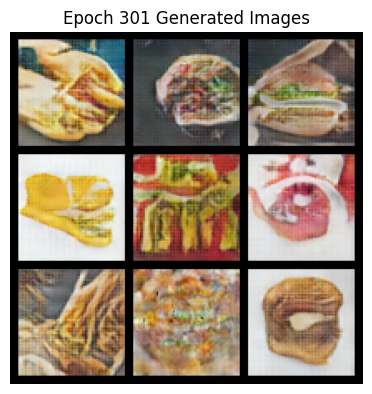

 60%|██████    | 302/500 [5:00:52<3:16:48, 59.64s/it]

Discriminator Loss EPOCH 302: 2374.0202
Generator Loss EPOCH 302: 7.7886


 61%|██████    | 303/500 [5:01:51<3:14:32, 59.25s/it]

Discriminator Loss EPOCH 303: 1022.8372
Generator Loss EPOCH 303: 6.4718


 61%|██████    | 304/500 [5:02:49<3:12:48, 59.02s/it]

Discriminator Loss EPOCH 304: 381.8876
Generator Loss EPOCH 304: 6.8957


 61%|██████    | 305/500 [5:03:48<3:11:23, 58.89s/it]

Discriminator Loss EPOCH 305: 278.5599
Generator Loss EPOCH 305: 7.0046


 61%|██████    | 306/500 [5:04:46<3:09:38, 58.65s/it]

Discriminator Loss EPOCH 306: 231.9184
Generator Loss EPOCH 306: 6.7014


 61%|██████▏   | 307/500 [5:05:44<3:08:03, 58.46s/it]

Discriminator Loss EPOCH 307: 1257.8077
Generator Loss EPOCH 307: 6.8101


 62%|██████▏   | 308/500 [5:06:42<3:06:51, 58.39s/it]

Discriminator Loss EPOCH 308: 393.7814
Generator Loss EPOCH 308: 8.2940


 62%|██████▏   | 309/500 [5:07:40<3:05:32, 58.29s/it]

Discriminator Loss EPOCH 309: 190.1118
Generator Loss EPOCH 309: 6.6873


 62%|██████▏   | 310/500 [5:08:38<3:04:14, 58.18s/it]

Discriminator Loss EPOCH 310: 880.1048
Generator Loss EPOCH 310: 7.6333


 62%|██████▏   | 311/500 [5:09:36<3:03:24, 58.23s/it]

Discriminator Loss EPOCH 311: 180.9076
Generator Loss EPOCH 311: 6.8847


 62%|██████▏   | 312/500 [5:10:35<3:02:57, 58.39s/it]

Discriminator Loss EPOCH 312: 157.8940
Generator Loss EPOCH 312: 6.9386


 63%|██████▎   | 313/500 [5:11:34<3:02:35, 58.58s/it]

Discriminator Loss EPOCH 313: 125.1376
Generator Loss EPOCH 313: 7.0143


 63%|██████▎   | 314/500 [5:12:33<3:01:48, 58.65s/it]

Discriminator Loss EPOCH 314: 141.1396
Generator Loss EPOCH 314: 7.5453


 63%|██████▎   | 315/500 [5:13:32<3:01:04, 58.73s/it]

Discriminator Loss EPOCH 315: 123.0772
Generator Loss EPOCH 315: 7.1169


 63%|██████▎   | 316/500 [5:14:30<2:59:57, 58.68s/it]

Discriminator Loss EPOCH 316: 118.6687
Generator Loss EPOCH 316: 7.3939


 63%|██████▎   | 317/500 [5:15:29<2:58:42, 58.59s/it]

Discriminator Loss EPOCH 317: 117.9440
Generator Loss EPOCH 317: 7.5299


 64%|██████▎   | 318/500 [5:16:28<2:57:48, 58.62s/it]

Discriminator Loss EPOCH 318: 143.3608
Generator Loss EPOCH 318: 9.7788


 64%|██████▍   | 319/500 [5:17:26<2:56:48, 58.61s/it]

Discriminator Loss EPOCH 319: 230.5568
Generator Loss EPOCH 319: 10.2414


 64%|██████▍   | 320/500 [5:18:25<2:56:03, 58.68s/it]

Discriminator Loss EPOCH 320: 7779.6143
Generator Loss EPOCH 320: 9.8166


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


Discriminator Loss EPOCH 321: 491.0943
Generator Loss EPOCH 321: 7.8506


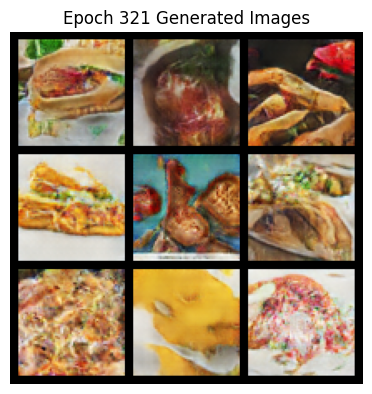

 64%|██████▍   | 322/500 [5:20:23<2:54:31, 58.83s/it]

Discriminator Loss EPOCH 322: 307.5531
Generator Loss EPOCH 322: 7.9790


 65%|██████▍   | 323/500 [5:21:21<2:52:52, 58.60s/it]

Discriminator Loss EPOCH 323: 202.0259
Generator Loss EPOCH 323: 7.5977


 65%|██████▍   | 324/500 [5:22:19<2:51:40, 58.53s/it]

Discriminator Loss EPOCH 324: 163.7571
Generator Loss EPOCH 324: 7.2225


 65%|██████▌   | 325/500 [5:23:18<2:51:10, 58.69s/it]

Discriminator Loss EPOCH 325: 183.0497
Generator Loss EPOCH 325: 8.2157


 65%|██████▌   | 326/500 [5:24:18<2:50:57, 58.95s/it]

Discriminator Loss EPOCH 326: 257.6227
Generator Loss EPOCH 326: 9.8962


 65%|██████▌   | 327/500 [5:25:17<2:49:40, 58.85s/it]

Discriminator Loss EPOCH 327: 163.6082
Generator Loss EPOCH 327: 9.3050


 66%|██████▌   | 328/500 [5:26:17<2:49:56, 59.28s/it]

Discriminator Loss EPOCH 328: 6449.5727
Generator Loss EPOCH 328: 8.2738


 66%|██████▌   | 329/500 [5:27:16<2:48:54, 59.27s/it]

Discriminator Loss EPOCH 329: 363.1788
Generator Loss EPOCH 329: 7.4796


 66%|██████▌   | 330/500 [5:28:15<2:47:22, 59.07s/it]

Discriminator Loss EPOCH 330: 245.5017
Generator Loss EPOCH 330: 6.7505


 66%|██████▌   | 331/500 [5:29:13<2:46:01, 58.95s/it]

Discriminator Loss EPOCH 331: 1492.9221
Generator Loss EPOCH 331: 8.7880


 66%|██████▋   | 332/500 [5:30:12<2:44:34, 58.77s/it]

Discriminator Loss EPOCH 332: 232.4002
Generator Loss EPOCH 332: 7.9401


 67%|██████▋   | 333/500 [5:31:10<2:43:22, 58.70s/it]

Discriminator Loss EPOCH 333: 209.7259
Generator Loss EPOCH 333: 8.0062


 67%|██████▋   | 334/500 [5:32:09<2:42:15, 58.65s/it]

Discriminator Loss EPOCH 334: 177.0003
Generator Loss EPOCH 334: 7.6329


 67%|██████▋   | 335/500 [5:33:08<2:41:49, 58.85s/it]

Discriminator Loss EPOCH 335: 1779.9660
Generator Loss EPOCH 335: 9.4272


 67%|██████▋   | 336/500 [5:34:07<2:41:11, 58.98s/it]

Discriminator Loss EPOCH 336: 239.6573
Generator Loss EPOCH 336: 7.8192


 67%|██████▋   | 337/500 [5:35:06<2:40:05, 58.93s/it]

Discriminator Loss EPOCH 337: 167.2764
Generator Loss EPOCH 337: 7.5176


 68%|██████▊   | 338/500 [5:36:05<2:38:55, 58.86s/it]

Discriminator Loss EPOCH 338: 171.0316
Generator Loss EPOCH 338: 7.7200


 68%|██████▊   | 339/500 [5:37:04<2:37:59, 58.88s/it]

Discriminator Loss EPOCH 339: 139.6141
Generator Loss EPOCH 339: 8.6440


 68%|██████▊   | 340/500 [5:38:03<2:37:09, 58.93s/it]

Discriminator Loss EPOCH 340: 129.6991
Generator Loss EPOCH 340: 7.6235


100%|██████████| 118/118 [00:59<00:00,  2.00it/s]


Discriminator Loss EPOCH 341: 113.9045
Generator Loss EPOCH 341: 7.4773


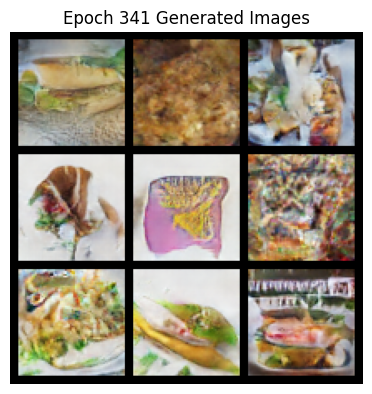

 68%|██████▊   | 342/500 [5:40:01<2:35:04, 58.89s/it]

Discriminator Loss EPOCH 342: 98.4378
Generator Loss EPOCH 342: 7.3530


 69%|██████▊   | 343/500 [5:41:00<2:34:40, 59.11s/it]

Discriminator Loss EPOCH 343: 91.3843
Generator Loss EPOCH 343: 7.5149


 69%|██████▉   | 344/500 [5:41:59<2:33:23, 58.99s/it]

Discriminator Loss EPOCH 344: 143.3770
Generator Loss EPOCH 344: 10.9843


 69%|██████▉   | 345/500 [5:42:58<2:32:12, 58.92s/it]

Discriminator Loss EPOCH 345: 90.0808
Generator Loss EPOCH 345: 7.8922


 69%|██████▉   | 346/500 [5:43:57<2:31:24, 58.99s/it]

Discriminator Loss EPOCH 346: 87.6922
Generator Loss EPOCH 346: 7.9570


 69%|██████▉   | 347/500 [5:44:56<2:30:13, 58.91s/it]

Discriminator Loss EPOCH 347: 104.2665
Generator Loss EPOCH 347: 10.0227


 70%|██████▉   | 348/500 [5:45:54<2:29:06, 58.86s/it]

Discriminator Loss EPOCH 348: 8517.4496
Generator Loss EPOCH 348: 11.6170


 70%|██████▉   | 349/500 [5:46:54<2:28:24, 58.97s/it]

Discriminator Loss EPOCH 349: 629.1225
Generator Loss EPOCH 349: 7.8894


 70%|███████   | 350/500 [5:47:53<2:27:32, 59.01s/it]

Discriminator Loss EPOCH 350: 334.1870
Generator Loss EPOCH 350: 8.4529


 70%|███████   | 351/500 [5:48:52<2:26:48, 59.12s/it]

Discriminator Loss EPOCH 351: 206.2009
Generator Loss EPOCH 351: 7.2107


 70%|███████   | 352/500 [5:49:52<2:26:06, 59.23s/it]

Discriminator Loss EPOCH 352: 1713.3593
Generator Loss EPOCH 352: 8.3215


 71%|███████   | 353/500 [5:50:50<2:24:47, 59.10s/it]

Discriminator Loss EPOCH 353: 210.0337
Generator Loss EPOCH 353: 7.7089


 71%|███████   | 354/500 [5:51:49<2:23:37, 59.03s/it]

Discriminator Loss EPOCH 354: 168.4185
Generator Loss EPOCH 354: 7.2133


 71%|███████   | 355/500 [5:52:48<2:22:24, 58.93s/it]

Discriminator Loss EPOCH 355: 161.6033
Generator Loss EPOCH 355: 8.0502


 71%|███████   | 356/500 [5:53:47<2:21:31, 58.97s/it]

Discriminator Loss EPOCH 356: 214.5311
Generator Loss EPOCH 356: 8.1287


 71%|███████▏  | 357/500 [5:54:46<2:20:23, 58.90s/it]

Discriminator Loss EPOCH 357: 343.4746
Generator Loss EPOCH 357: 7.3992


 72%|███████▏  | 358/500 [5:55:44<2:19:12, 58.82s/it]

Discriminator Loss EPOCH 358: 2537.7592
Generator Loss EPOCH 358: 9.7283


 72%|███████▏  | 359/500 [5:56:43<2:18:24, 58.90s/it]

Discriminator Loss EPOCH 359: 281.8913
Generator Loss EPOCH 359: 7.8914


 72%|███████▏  | 360/500 [5:57:43<2:17:42, 59.02s/it]

Discriminator Loss EPOCH 360: 190.2578
Generator Loss EPOCH 360: 7.6672


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Discriminator Loss EPOCH 361: 157.5435
Generator Loss EPOCH 361: 7.6182


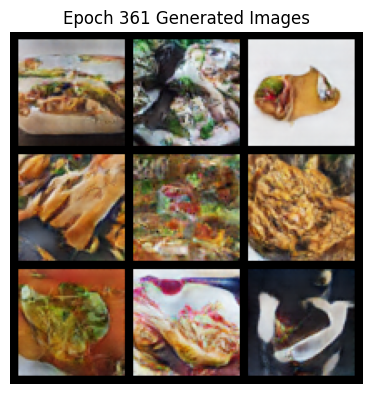

 72%|███████▏  | 362/500 [5:59:40<2:15:29, 58.91s/it]

Discriminator Loss EPOCH 362: 267.5026
Generator Loss EPOCH 362: 9.9461


 73%|███████▎  | 363/500 [6:00:39<2:14:35, 58.94s/it]

Discriminator Loss EPOCH 363: 137.0097
Generator Loss EPOCH 363: 8.2311


 73%|███████▎  | 364/500 [6:01:39<2:14:02, 59.14s/it]

Discriminator Loss EPOCH 364: 137.6864
Generator Loss EPOCH 364: 9.4590


 73%|███████▎  | 365/500 [6:02:39<2:13:37, 59.39s/it]

Discriminator Loss EPOCH 365: 122.7985
Generator Loss EPOCH 365: 8.0755


 73%|███████▎  | 366/500 [6:03:39<2:13:00, 59.55s/it]

Discriminator Loss EPOCH 366: 98.3147
Generator Loss EPOCH 366: 8.2646


 73%|███████▎  | 367/500 [6:04:38<2:11:41, 59.41s/it]

Discriminator Loss EPOCH 367: 2721.2539
Generator Loss EPOCH 367: 9.7154


 74%|███████▎  | 368/500 [6:05:38<2:10:52, 59.49s/it]

Discriminator Loss EPOCH 368: 271.5700
Generator Loss EPOCH 368: 7.6800


 74%|███████▍  | 369/500 [6:06:37<2:09:32, 59.33s/it]

Discriminator Loss EPOCH 369: 185.1235
Generator Loss EPOCH 369: 8.4283


 74%|███████▍  | 370/500 [6:07:35<2:08:04, 59.12s/it]

Discriminator Loss EPOCH 370: 188.7809
Generator Loss EPOCH 370: 9.2675


 74%|███████▍  | 371/500 [6:08:34<2:06:40, 58.92s/it]

Discriminator Loss EPOCH 371: 145.4509
Generator Loss EPOCH 371: 8.3671


 74%|███████▍  | 372/500 [6:09:33<2:05:57, 59.04s/it]

Discriminator Loss EPOCH 372: 122.0988
Generator Loss EPOCH 372: 8.3979


 75%|███████▍  | 373/500 [6:10:35<2:06:46, 59.90s/it]

Discriminator Loss EPOCH 373: 110.0186
Generator Loss EPOCH 373: 8.2914


 75%|███████▍  | 374/500 [6:11:36<2:06:13, 60.11s/it]

Discriminator Loss EPOCH 374: 432.1560
Generator Loss EPOCH 374: 10.6356


 75%|███████▌  | 375/500 [6:12:35<2:04:38, 59.83s/it]

Discriminator Loss EPOCH 375: 111.7303
Generator Loss EPOCH 375: 9.2836


 75%|███████▌  | 376/500 [6:13:33<2:02:52, 59.45s/it]

Discriminator Loss EPOCH 376: 83.0279
Generator Loss EPOCH 376: 7.6941


 75%|███████▌  | 377/500 [6:14:32<2:01:30, 59.27s/it]

Discriminator Loss EPOCH 377: 76.7531
Generator Loss EPOCH 377: 7.8973


 76%|███████▌  | 378/500 [6:15:32<2:01:01, 59.52s/it]

Discriminator Loss EPOCH 378: 77.3914
Generator Loss EPOCH 378: 8.0833


 76%|███████▌  | 379/500 [6:16:34<2:01:25, 60.21s/it]

Discriminator Loss EPOCH 379: 74.9951
Generator Loss EPOCH 379: 8.0623


 76%|███████▌  | 380/500 [6:17:34<2:00:19, 60.16s/it]

Discriminator Loss EPOCH 380: 85.6678
Generator Loss EPOCH 380: 8.9634


100%|██████████| 118/118 [00:58<00:00,  2.02it/s]


Discriminator Loss EPOCH 381: 101.0868
Generator Loss EPOCH 381: 9.9865


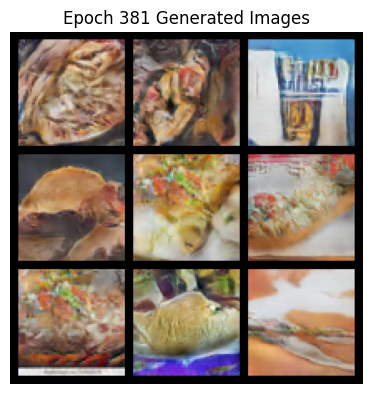

 76%|███████▋  | 382/500 [6:19:31<1:56:48, 59.40s/it]

Discriminator Loss EPOCH 382: 8584.4454
Generator Loss EPOCH 382: 13.5390


 77%|███████▋  | 383/500 [6:20:30<1:55:34, 59.27s/it]

Discriminator Loss EPOCH 383: 471.4300
Generator Loss EPOCH 383: 9.4286


 77%|███████▋  | 384/500 [6:21:30<1:54:50, 59.41s/it]

Discriminator Loss EPOCH 384: 297.8873
Generator Loss EPOCH 384: 9.6086


 77%|███████▋  | 385/500 [6:22:29<1:53:27, 59.20s/it]

Discriminator Loss EPOCH 385: 235.1138
Generator Loss EPOCH 385: 7.5025


 77%|███████▋  | 386/500 [6:23:27<1:51:47, 58.84s/it]

Discriminator Loss EPOCH 386: 1741.1592
Generator Loss EPOCH 386: 8.3159


 77%|███████▋  | 387/500 [6:24:25<1:50:35, 58.72s/it]

Discriminator Loss EPOCH 387: 229.0456
Generator Loss EPOCH 387: 8.1265


 78%|███████▊  | 388/500 [6:25:24<1:49:22, 58.60s/it]

Discriminator Loss EPOCH 388: 149.1490
Generator Loss EPOCH 388: 7.2253


 78%|███████▊  | 389/500 [6:26:22<1:48:18, 58.55s/it]

Discriminator Loss EPOCH 389: 128.6494
Generator Loss EPOCH 389: 7.7793


 78%|███████▊  | 390/500 [6:27:21<1:47:30, 58.64s/it]

Discriminator Loss EPOCH 390: 116.9605
Generator Loss EPOCH 390: 8.0088


 78%|███████▊  | 391/500 [6:28:19<1:46:29, 58.62s/it]

Discriminator Loss EPOCH 391: 115.2833
Generator Loss EPOCH 391: 7.7577


 78%|███████▊  | 392/500 [6:29:18<1:45:27, 58.59s/it]

Discriminator Loss EPOCH 392: 99.9423
Generator Loss EPOCH 392: 7.6224


 79%|███████▊  | 393/500 [6:30:17<1:44:30, 58.60s/it]

Discriminator Loss EPOCH 393: 2298.3833
Generator Loss EPOCH 393: 11.5073


 79%|███████▉  | 394/500 [6:31:16<1:44:04, 58.91s/it]

Discriminator Loss EPOCH 394: 308.9945
Generator Loss EPOCH 394: 8.7503


 79%|███████▉  | 395/500 [6:32:20<1:45:43, 60.41s/it]

Discriminator Loss EPOCH 395: 157.4524
Generator Loss EPOCH 395: 8.2514


 79%|███████▉  | 396/500 [6:33:24<1:46:20, 61.36s/it]

Discriminator Loss EPOCH 396: 137.7106
Generator Loss EPOCH 396: 7.5924


 79%|███████▉  | 397/500 [6:34:28<1:46:50, 62.23s/it]

Discriminator Loss EPOCH 397: 143.8434
Generator Loss EPOCH 397: 8.5847


 80%|███████▉  | 398/500 [6:35:32<1:46:57, 62.91s/it]

Discriminator Loss EPOCH 398: 121.1422
Generator Loss EPOCH 398: 9.1930


 80%|███████▉  | 399/500 [6:36:37<1:46:43, 63.40s/it]

Discriminator Loss EPOCH 399: 96.3496
Generator Loss EPOCH 399: 8.0701


100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Discriminator Loss EPOCH 400: 1252.9157
Generator Loss EPOCH 400: 10.9066


 80%|████████  | 400/500 [6:37:41<1:46:03, 63.64s/it]

Checkpoint saved at epoch 399


100%|██████████| 118/118 [01:04<00:00,  1.84it/s]

Discriminator Loss EPOCH 401: 309.5669
Generator Loss EPOCH 401: 10.3824


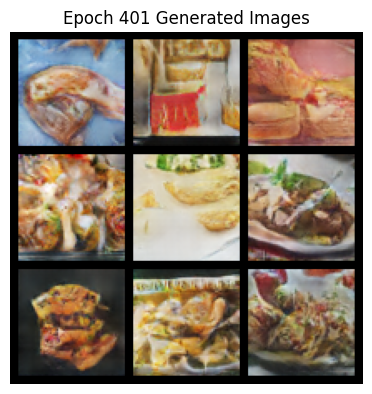

 80%|████████  | 402/500 [6:39:50<1:44:20, 63.88s/it]

Discriminator Loss EPOCH 402: 150.7496
Generator Loss EPOCH 402: 8.9480


 81%|████████  | 403/500 [6:40:53<1:43:08, 63.80s/it]

Discriminator Loss EPOCH 403: 125.0646
Generator Loss EPOCH 403: 8.1147


 81%|████████  | 404/500 [6:41:57<1:42:18, 63.94s/it]

Discriminator Loss EPOCH 404: 101.2408
Generator Loss EPOCH 404: 9.3489


 81%|████████  | 405/500 [6:43:01<1:40:51, 63.70s/it]

Discriminator Loss EPOCH 405: 90.6183
Generator Loss EPOCH 405: 7.8903


 81%|████████  | 406/500 [6:44:06<1:40:38, 64.24s/it]

Discriminator Loss EPOCH 406: 85.8704
Generator Loss EPOCH 406: 8.0519


 81%|████████▏ | 407/500 [6:45:10<1:39:23, 64.12s/it]

Discriminator Loss EPOCH 407: 97.4705
Generator Loss EPOCH 407: 8.8777


 82%|████████▏ | 408/500 [6:46:12<1:37:23, 63.52s/it]

Discriminator Loss EPOCH 408: 84.5064
Generator Loss EPOCH 408: 9.6564


 82%|████████▏ | 409/500 [6:47:12<1:34:54, 62.58s/it]

Discriminator Loss EPOCH 409: 70.1138
Generator Loss EPOCH 409: 8.6855


 82%|████████▏ | 410/500 [6:48:12<1:32:28, 61.65s/it]

Discriminator Loss EPOCH 410: 77.6233
Generator Loss EPOCH 410: 8.8487


 82%|████████▏ | 411/500 [6:49:13<1:31:04, 61.40s/it]

Discriminator Loss EPOCH 411: 3672.0444
Generator Loss EPOCH 411: 11.4107


 82%|████████▏ | 412/500 [6:50:13<1:29:28, 61.01s/it]

Discriminator Loss EPOCH 412: 823.0013
Generator Loss EPOCH 412: 10.7054


 83%|████████▎ | 413/500 [6:51:12<1:27:38, 60.44s/it]

Discriminator Loss EPOCH 413: 285.7549
Generator Loss EPOCH 413: 9.1452


 83%|████████▎ | 414/500 [6:52:11<1:26:07, 60.09s/it]

Discriminator Loss EPOCH 414: 280.4745
Generator Loss EPOCH 414: 8.5047


 83%|████████▎ | 415/500 [6:53:10<1:24:39, 59.75s/it]

Discriminator Loss EPOCH 415: 145.1345
Generator Loss EPOCH 415: 7.9354


 83%|████████▎ | 416/500 [6:54:10<1:23:30, 59.65s/it]

Discriminator Loss EPOCH 416: 111.4582
Generator Loss EPOCH 416: 8.8608


 83%|████████▎ | 417/500 [6:55:09<1:22:28, 59.61s/it]

Discriminator Loss EPOCH 417: 116.5268
Generator Loss EPOCH 417: 8.0680


 84%|████████▎ | 418/500 [6:56:10<1:21:51, 59.89s/it]

Discriminator Loss EPOCH 418: 95.9957
Generator Loss EPOCH 418: 7.9731


 84%|████████▍ | 419/500 [6:57:12<1:21:42, 60.52s/it]

Discriminator Loss EPOCH 419: 87.3412
Generator Loss EPOCH 419: 8.1904


 84%|████████▍ | 420/500 [6:58:13<1:21:07, 60.84s/it]

Discriminator Loss EPOCH 420: 84.2003
Generator Loss EPOCH 420: 9.0074


100%|██████████| 118/118 [00:59<00:00,  1.97it/s]


Discriminator Loss EPOCH 421: 106.7330
Generator Loss EPOCH 421: 9.9554


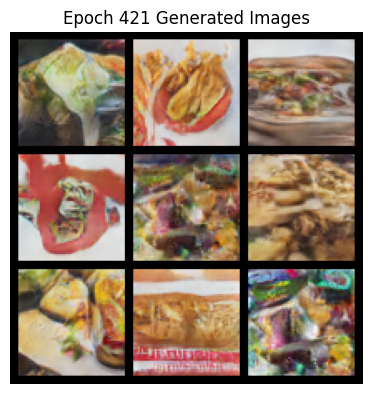

 84%|████████▍ | 422/500 [7:00:12<1:18:07, 60.10s/it]

Discriminator Loss EPOCH 422: 97.1541
Generator Loss EPOCH 422: 11.8268


 85%|████████▍ | 423/500 [7:01:11<1:16:40, 59.74s/it]

Discriminator Loss EPOCH 423: 3557.4200
Generator Loss EPOCH 423: 12.2821


 85%|████████▍ | 424/500 [7:02:10<1:15:16, 59.42s/it]

Discriminator Loss EPOCH 424: 446.6188
Generator Loss EPOCH 424: 10.0895


 85%|████████▌ | 425/500 [7:03:09<1:14:02, 59.23s/it]

Discriminator Loss EPOCH 425: 198.0146
Generator Loss EPOCH 425: 9.5847


 85%|████████▌ | 426/500 [7:04:07<1:12:47, 59.02s/it]

Discriminator Loss EPOCH 426: 481.8017
Generator Loss EPOCH 426: 8.5761


 85%|████████▌ | 427/500 [7:05:06<1:11:36, 58.86s/it]

Discriminator Loss EPOCH 427: 148.1933
Generator Loss EPOCH 427: 7.8469


 86%|████████▌ | 428/500 [7:06:05<1:10:52, 59.06s/it]

Discriminator Loss EPOCH 428: 113.7734
Generator Loss EPOCH 428: 7.9810


 86%|████████▌ | 429/500 [7:07:05<1:10:02, 59.19s/it]

Discriminator Loss EPOCH 429: 133.5047
Generator Loss EPOCH 429: 8.4137


 86%|████████▌ | 430/500 [7:08:03<1:08:54, 59.06s/it]

Discriminator Loss EPOCH 430: 205.0186
Generator Loss EPOCH 430: 10.5981


 86%|████████▌ | 431/500 [7:09:02<1:07:45, 58.92s/it]

Discriminator Loss EPOCH 431: 135.8920
Generator Loss EPOCH 431: 10.5345


 86%|████████▋ | 432/500 [7:10:00<1:06:33, 58.72s/it]

Discriminator Loss EPOCH 432: 2309.8824
Generator Loss EPOCH 432: 11.2762


 87%|████████▋ | 433/500 [7:10:59<1:05:30, 58.67s/it]

Discriminator Loss EPOCH 433: 283.6976
Generator Loss EPOCH 433: 8.9940


 87%|████████▋ | 434/500 [7:11:58<1:04:36, 58.73s/it]

Discriminator Loss EPOCH 434: 531.5932
Generator Loss EPOCH 434: 9.3614


 87%|████████▋ | 435/500 [7:12:56<1:03:35, 58.70s/it]

Discriminator Loss EPOCH 435: 131.6671
Generator Loss EPOCH 435: 9.1941


 87%|████████▋ | 436/500 [7:13:55<1:02:34, 58.67s/it]

Discriminator Loss EPOCH 436: 127.1180
Generator Loss EPOCH 436: 10.5819


 87%|████████▋ | 437/500 [7:14:53<1:01:33, 58.63s/it]

Discriminator Loss EPOCH 437: 1784.4306
Generator Loss EPOCH 437: 9.6932


 88%|████████▊ | 438/500 [7:15:52<1:00:31, 58.57s/it]

Discriminator Loss EPOCH 438: 195.9494
Generator Loss EPOCH 438: 10.4198


 88%|████████▊ | 439/500 [7:16:50<59:34, 58.60s/it]  

Discriminator Loss EPOCH 439: 138.3325
Generator Loss EPOCH 439: 10.4658


 88%|████████▊ | 440/500 [7:17:49<58:39, 58.65s/it]

Discriminator Loss EPOCH 440: 103.4564
Generator Loss EPOCH 440: 9.3946


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Discriminator Loss EPOCH 441: 110.5529
Generator Loss EPOCH 441: 10.2065


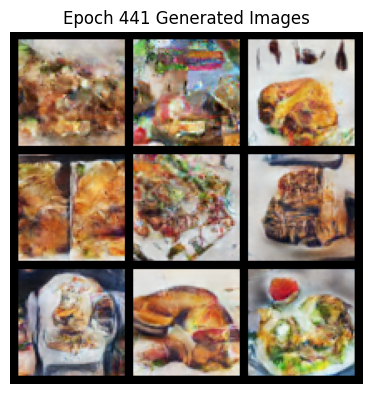

 88%|████████▊ | 442/500 [7:19:47<56:41, 58.66s/it]

Discriminator Loss EPOCH 442: 84.4763
Generator Loss EPOCH 442: 7.8975


 89%|████████▊ | 443/500 [7:20:45<55:42, 58.64s/it]

Discriminator Loss EPOCH 443: 80.6390
Generator Loss EPOCH 443: 7.8674


 89%|████████▉ | 444/500 [7:21:44<54:45, 58.68s/it]

Discriminator Loss EPOCH 444: 75.0276
Generator Loss EPOCH 444: 9.7704


 89%|████████▉ | 445/500 [7:22:42<53:41, 58.58s/it]

Discriminator Loss EPOCH 445: 71.4047
Generator Loss EPOCH 445: 9.7848


 89%|████████▉ | 446/500 [7:23:41<52:40, 58.53s/it]

Discriminator Loss EPOCH 446: 69.5305
Generator Loss EPOCH 446: 8.3033


 89%|████████▉ | 447/500 [7:24:39<51:37, 58.44s/it]

Discriminator Loss EPOCH 447: 72.0778
Generator Loss EPOCH 447: 9.5971


 90%|████████▉ | 448/500 [7:25:38<50:51, 58.68s/it]

Discriminator Loss EPOCH 448: 3509.9651
Generator Loss EPOCH 448: 13.1759


 90%|████████▉ | 449/500 [7:26:37<49:49, 58.62s/it]

Discriminator Loss EPOCH 449: 218.9486
Generator Loss EPOCH 449: 9.9987


 90%|█████████ | 450/500 [7:27:35<48:52, 58.64s/it]

Discriminator Loss EPOCH 450: 157.7908
Generator Loss EPOCH 450: 8.1560


 90%|█████████ | 451/500 [7:28:34<47:51, 58.61s/it]

Discriminator Loss EPOCH 451: 107.2731
Generator Loss EPOCH 451: 8.7564


 90%|█████████ | 452/500 [7:29:32<46:50, 58.56s/it]

Discriminator Loss EPOCH 452: 84.3874
Generator Loss EPOCH 452: 7.9249


 91%|█████████ | 453/500 [7:30:31<45:50, 58.52s/it]

Discriminator Loss EPOCH 453: 105.5024
Generator Loss EPOCH 453: 8.8208


 91%|█████████ | 454/500 [7:31:29<44:50, 58.48s/it]

Discriminator Loss EPOCH 454: 211.8696
Generator Loss EPOCH 454: 13.8340


 91%|█████████ | 455/500 [7:32:29<44:04, 58.77s/it]

Discriminator Loss EPOCH 455: 156.4213
Generator Loss EPOCH 455: 11.2242


 91%|█████████ | 456/500 [7:33:27<43:07, 58.80s/it]

Discriminator Loss EPOCH 456: 85.0794
Generator Loss EPOCH 456: 9.0393


 91%|█████████▏| 457/500 [7:34:26<42:05, 58.72s/it]

Discriminator Loss EPOCH 457: 67.9966
Generator Loss EPOCH 457: 8.4985


 92%|█████████▏| 458/500 [7:35:26<41:20, 59.05s/it]

Discriminator Loss EPOCH 458: 71.5150
Generator Loss EPOCH 458: 9.0701


 92%|█████████▏| 459/500 [7:36:25<40:24, 59.13s/it]

Discriminator Loss EPOCH 459: 4542.8945
Generator Loss EPOCH 459: 10.9329


 92%|█████████▏| 460/500 [7:37:25<39:33, 59.34s/it]

Discriminator Loss EPOCH 460: 1442.6881
Generator Loss EPOCH 460: 12.1129


100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


Discriminator Loss EPOCH 461: 398.8164
Generator Loss EPOCH 461: 10.6606


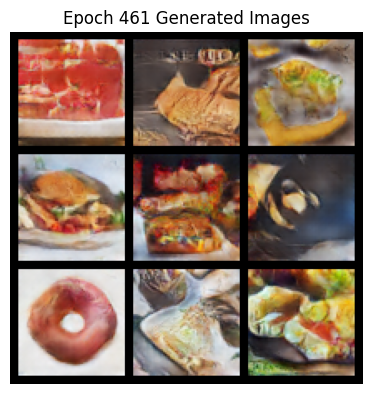

 92%|█████████▏| 462/500 [7:39:26<37:59, 59.98s/it]

Discriminator Loss EPOCH 462: 242.3418
Generator Loss EPOCH 462: 8.5341


 93%|█████████▎| 463/500 [7:40:25<36:48, 59.68s/it]

Discriminator Loss EPOCH 463: 192.5690
Generator Loss EPOCH 463: 8.8749


 93%|█████████▎| 464/500 [7:41:24<35:37, 59.38s/it]

Discriminator Loss EPOCH 464: 168.9346
Generator Loss EPOCH 464: 9.3775


 93%|█████████▎| 465/500 [7:42:23<34:29, 59.12s/it]

Discriminator Loss EPOCH 465: 230.8473
Generator Loss EPOCH 465: 9.8702


 93%|█████████▎| 466/500 [7:43:21<33:23, 58.93s/it]

Discriminator Loss EPOCH 466: 106.5187
Generator Loss EPOCH 466: 8.2438


 93%|█████████▎| 467/500 [7:44:20<32:23, 58.91s/it]

Discriminator Loss EPOCH 467: 97.9411
Generator Loss EPOCH 467: 8.2073


 94%|█████████▎| 468/500 [7:45:19<31:23, 58.86s/it]

Discriminator Loss EPOCH 468: 116.7028
Generator Loss EPOCH 468: 10.2706


 94%|█████████▍| 469/500 [7:46:17<30:21, 58.76s/it]

Discriminator Loss EPOCH 469: 1608.0872
Generator Loss EPOCH 469: 11.2476


 94%|█████████▍| 470/500 [7:47:15<29:18, 58.62s/it]

Discriminator Loss EPOCH 470: 204.7455
Generator Loss EPOCH 470: 9.6939


 94%|█████████▍| 471/500 [7:48:14<28:19, 58.60s/it]

Discriminator Loss EPOCH 471: 131.8254
Generator Loss EPOCH 471: 8.3453


 94%|█████████▍| 472/500 [7:49:13<27:21, 58.63s/it]

Discriminator Loss EPOCH 472: 141.5531
Generator Loss EPOCH 472: 9.0927


 95%|█████████▍| 473/500 [7:50:11<26:23, 58.65s/it]

Discriminator Loss EPOCH 473: 102.6539
Generator Loss EPOCH 473: 12.6633


 95%|█████████▍| 474/500 [7:51:10<25:25, 58.68s/it]

Discriminator Loss EPOCH 474: 96.3426
Generator Loss EPOCH 474: 9.2025


 95%|█████████▌| 475/500 [7:52:09<24:28, 58.73s/it]

Discriminator Loss EPOCH 475: 73.3170
Generator Loss EPOCH 475: 8.9197


 95%|█████████▌| 476/500 [7:53:08<23:33, 58.90s/it]

Discriminator Loss EPOCH 476: 75.4745
Generator Loss EPOCH 476: 8.6474


 95%|█████████▌| 477/500 [7:54:08<22:37, 59.03s/it]

Discriminator Loss EPOCH 477: 67.8964
Generator Loss EPOCH 477: 8.1639


 96%|█████████▌| 478/500 [7:55:06<21:36, 58.94s/it]

Discriminator Loss EPOCH 478: 3271.5588
Generator Loss EPOCH 478: 12.6799


 96%|█████████▌| 479/500 [7:56:06<20:42, 59.16s/it]

Discriminator Loss EPOCH 479: 237.8930
Generator Loss EPOCH 479: 8.0618


 96%|█████████▌| 480/500 [7:57:05<19:43, 59.19s/it]

Discriminator Loss EPOCH 480: 151.0166
Generator Loss EPOCH 480: 8.0751


100%|██████████| 118/118 [00:59<00:00,  1.97it/s]


Discriminator Loss EPOCH 481: 157.4608
Generator Loss EPOCH 481: 11.1093


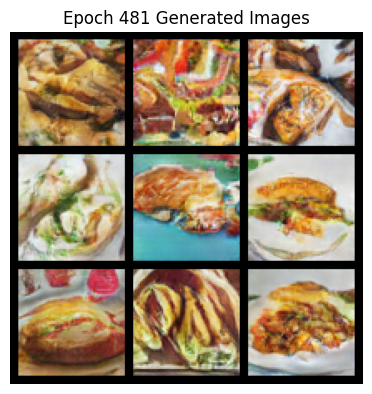

 96%|█████████▋| 482/500 [7:59:05<17:53, 59.64s/it]

Discriminator Loss EPOCH 482: 97.0696
Generator Loss EPOCH 482: 8.5128


 97%|█████████▋| 483/500 [8:00:05<16:51, 59.52s/it]

Discriminator Loss EPOCH 483: 96.3314
Generator Loss EPOCH 483: 8.1351


 97%|█████████▋| 484/500 [8:01:03<15:49, 59.33s/it]

Discriminator Loss EPOCH 484: 106.2013
Generator Loss EPOCH 484: 9.5241


 97%|█████████▋| 485/500 [8:02:02<14:45, 59.06s/it]

Discriminator Loss EPOCH 485: 78.1118
Generator Loss EPOCH 485: 8.8219


 97%|█████████▋| 486/500 [8:03:01<13:47, 59.12s/it]

Discriminator Loss EPOCH 486: 82.8815
Generator Loss EPOCH 486: 9.6239


 97%|█████████▋| 487/500 [8:04:00<12:46, 58.95s/it]

Discriminator Loss EPOCH 487: 94.4384
Generator Loss EPOCH 487: 9.2103


 98%|█████████▊| 488/500 [8:04:59<11:46, 58.90s/it]

Discriminator Loss EPOCH 488: 4688.0267
Generator Loss EPOCH 488: 12.9117


 98%|█████████▊| 489/500 [8:05:57<10:46, 58.77s/it]

Discriminator Loss EPOCH 489: 303.5681
Generator Loss EPOCH 489: 12.3885


 98%|█████████▊| 490/500 [8:06:56<09:47, 58.76s/it]

Discriminator Loss EPOCH 490: 169.4853
Generator Loss EPOCH 490: 10.9419


 98%|█████████▊| 491/500 [8:07:54<08:48, 58.75s/it]

Discriminator Loss EPOCH 491: 209.5762
Generator Loss EPOCH 491: 11.4606


 98%|█████████▊| 492/500 [8:08:55<07:53, 59.18s/it]

Discriminator Loss EPOCH 492: 118.3344
Generator Loss EPOCH 492: 9.9336


 99%|█████████▊| 493/500 [8:09:55<06:57, 59.58s/it]

Discriminator Loss EPOCH 493: 87.8260
Generator Loss EPOCH 493: 8.1592


 99%|█████████▉| 494/500 [8:10:54<05:55, 59.21s/it]

Discriminator Loss EPOCH 494: 112.9957
Generator Loss EPOCH 494: 10.2591


 99%|█████████▉| 495/500 [8:11:52<04:55, 59.07s/it]

Discriminator Loss EPOCH 495: 82.9008
Generator Loss EPOCH 495: 9.4719


 99%|█████████▉| 496/500 [8:12:51<03:55, 58.93s/it]

Discriminator Loss EPOCH 496: 3500.1513
Generator Loss EPOCH 496: 11.7484


 99%|█████████▉| 497/500 [8:13:50<02:56, 58.87s/it]

Discriminator Loss EPOCH 497: 859.5457
Generator Loss EPOCH 497: 12.1799


100%|█████████▉| 498/500 [8:14:49<01:57, 58.96s/it]

Discriminator Loss EPOCH 498: 303.9457
Generator Loss EPOCH 498: 10.9125


100%|█████████▉| 499/500 [8:15:48<00:58, 58.97s/it]

Discriminator Loss EPOCH 499: 162.1461
Generator Loss EPOCH 499: 8.7606


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


Discriminator Loss EPOCH 500: 131.2169
Generator Loss EPOCH 500: 8.3780


100%|██████████| 500/500 [8:16:47<00:00, 59.62s/it]

Checkpoint saved at epoch 499
Training time: 29807.51s


In [15]:
criterion = nn.BCELoss()

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))

generator.train()
discriminator.train()

generator_params = sum(p.numel() for p in generator.parameters())
discriminator_params = sum(p.numel() for p in discriminator.parameters())

print(f"Generator params: {generator_params}")
print(f"Discriminator params: {discriminator_params}")

def save_checkpoint(epoch, generator, discriminator, gen_opt, disc_opt, checkpoint_dir=CHECKPOINT):
    checkpoint = {
        "epoch": epoch,
        "generator_state_dict":  generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "generator_optimizer_state_dict": gen_opt.state_dict(),
        "discriminator_optimizer_state_dict": disc_opt.state_dict(),
    }
    torch.save(checkpoint, f"{CHECKPOINT}/checkpoint_epoch_{epoch}.pth")
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(checkpoint_path, generator, discriminator, gen_opt, disc_opt):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    gen_opt.load_state_dict(checkpoint["gen_opt_state_dict"])
    disc_opt.load_state_dict(checkpoint["disc_opt_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    return start_epoch

start_epoch = 0

resume_training = False
checkpoint_path = f"{CHECKPOINT}/checkpoint_epoch_100.pth"

if resume_training:
    start_epoch = load_checkpoint(checkpoint_path, generator, discriminator, generator_optimizer, discriminator_optimizer)

start = timeit.default_timer()
for epoch in tqdm(range(start_epoch, EPOCHS), position=0, leave=True):
  generator_running_lost = 0
  discriminator_running_lost = 0
  for idx, data in enumerate(tqdm(dataloader, position=0, leave=True)):
    img_data = data[0].to(device)
    dummy_labels = data[1]

    real_labels = torch.full((dummy_labels.size()), 1., dtype=torch.float).to(device)
    fake_labels = torch.full((dummy_labels.size()), 0., dtype=torch.float).to(device)

    discriminator_real_out = discriminator(img_data).view(-1)
    discriminator_real_loss = criterion(discriminator_real_out, real_labels)
    discriminator.zero_grad()
    discriminator_real_loss.backward()

    noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)
    generator_fake_out = generator(noise)
    discriminator_fake_out = discriminator(generator_fake_out.detach()).view(-1)
    discriminator_fake_loss = criterion(discriminator_fake_out, fake_labels)
    discriminator_fake_loss.backward()
    discriminator_running_lost += discriminator_real_loss.item() + discriminator_fake_loss.item()
    discriminator_optimizer.step()

    discriminator_fake_out = discriminator(generator_fake_out).view(-1)
    generator_loss = criterion(discriminator_fake_out, real_labels)
    generator_running_lost += generator_loss.item()
    generator.zero_grad()
    generator_loss.backward()
    generator_optimizer.step()

  discriminator_loss = discriminator_running_lost / 2 *(idx+1)
  generator_loss = generator_running_lost / (idx+1)

  print(f"Discriminator Loss EPOCH {epoch+1}: {discriminator_loss:.4f}")
  print(f"Generator Loss EPOCH {epoch+1}: {generator_loss:.4f}")

  if epoch % 20 == 0:  
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(), (1,2,0)))
    plt.show()

  if (epoch + 1) % 100 == 0:
    save_checkpoint(epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)

stop = timeit.default_timer()
print(f"Training time: {stop-start:.2f}s")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)
generator_fake_out = generator(noise)
plt.imshow(generator_fake_out[2].detach().cpu().permute(1, 2, 0))

In [ ]:
https://www.kaggle.com/code/ashishpatel26/gan-beginner-tutorial-for-pytorch-celeba-dataset?scriptVersionId=6886724&cellId=23

In [ ]:
import imageio

images = []
for epoch in range(EPOCHS):
    for i in range(total_batch):
        if(i+1)%sample_step == 0:
            img_name = '../fake_samples-' + str(epoch + 1) + '-' + str(i + 1) + '.png'
            images.append(imageio.imread(img_name))
            print("epoch : {}, step : {}".format(epoch+1, i+1))
imageio.mimsave('dcgan_celebA_generation_animation.gif', images, fps=5)